# TAO (0, 140) χpod

## TODO


1. 1023.5 surface does not exist south of 2N? Something is weird. More generally how do I deal with ECCO bias? Or I need to choose bins based on outcrops I guess
1. Argo spline fits are a little steep
1. Estimate gradients at latitude=0, exactly


1. Understand regrid_conservative: Am I providign bin edges or bin centers.
2. Then do the right thing to get derivative.


Think about EUC max

In [1]:
%aimport cf_xarray
%aimport dcpy
%aimport eddydiff
%aimport xgcm

import distributed
import eddydiff as ed
import hvplot.xarray
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pump

import xarray as xr

xr.set_options(keep_attrs=True)

plt.rcParams['figure.dpi'] = 180
plt.rcParams["savefig.dpi"] = 200

client = distributed.Client()
client

<Client: 'tcp://127.0.0.1:45583' processes=4 threads=8, memory=33.39 GB>

---
---

## Read χpod , TAO data

In [148]:
chi = (
    xr.open_dataset(
        "~/datasets/chipod/tao/chipods_0_140W.nc",
        decode_cf=False,
        chunks={"time": 10000},
    )
    .set_coords(["mooring", "chipod", "crs"])
    .swap_dims({"timeSeries": "depth"})
    .rename({"Kt": "KT", "Nsqr": "N2"})
    .drop(["timeSeries", "crs"])
)
for var in chi.variables:
    if "FillValue" in chi[var].attrs:
        chi[var].attrs["_FillValue"] = int(chi[var].attrs["FillValue"])
chi = xr.decode_cf(chi)
chi["T"] -= 273
chi.T.attrs["units"] = "C"
chi["KtTz"] = chi.KT * chi.dTdz
chi["lat"] = chi.lat[0].load()
chi["lon"] = chi.lon[0].load()

chisub = chi.sel(time=slice("2008-05-01", "2009-05-01"))


tao = xr.open_mfdataset(
    "/home/deepak/datasets/TaoTritonPirataRama/TAO_TRITON/[ts]_xyzt_dy.cdf",
    chunks={"depth": 10, "time": 8000},
)


for var in ["T_20", "S_41"]:
    tao[var].attrs["missing_value"] = tao.attrs["missing_value"]
    tao[var].attrs["_FillValue"] = tao.attrs["_FillValue"]
tao = xr.decode_cf(tao).rename({"T_20": "T", "S_41": "S"})
tao = tao.cf.guess_coord_axis()
tao = tao.assign_coords(lon=tao.lon - 360)
tao = tao[["S", "T"]]


def calc_mld(pden):

    drho = pden - pden.cf.isel(Z=0)
    return xr.where(drho > 0.015, np.abs(drho.cf["Z"]), np.nan).cf.min("Z")


def subset_mooring_to_chipod(tao, chipod):
    taos = (
        tao.sel(
            lat=chipod.lat.load().item(),
            lon=chipod.lon.load().item(),
            method="nearest",
        )
        .sel(
            time=slice(chipod.time[0], chipod.time[-1]),
            depth=slice(chipod.depth.max().item() + 20),
        )
        .load()
        .dropna("depth", how="all")
        .dropna("time", how="all")
        # .interpolate_na("depth")
        .interpolate_na("time", max_gap="2D")
    )

    return taos


taos = subset_mooring_to_chipod(tao, chisub)
taos["rho"] = dcpy.eos.pden(taos.S.interpolate_na("depth"), taos.T, 0, pr=0)
taos["rhoT"] = dcpy.eos.pden(35, taos.T, 0, pr=0)
taos["rho"].attrs.update({"long_name": "$ρ$", "units": "kg/m³"})
taos["rhoT"].attrs.update({"long_name": "$ρ^T$", "units": "kg/m³"})
taos["mld"] = calc_mld(taos.rhoT)

fastT = xr.open_mfdataset(
    "/home/deepak/datasets/TaoTritonPirataRama/high_resolution/10m/t0n140w_10m.cdf",
    chunks={"depth": 10, "time": 8000},
).T_20
fastT = subset_mooring_to_chipod(fastT, chisub)

# TODO: get salinity?
chisub = chisub.rename({"T": "T_original"})
chisub["T"] = fastT.interp(depth=chisub.depth)
chisub["pden"] = dcpy.eos.pden(35, chisub.T, 0, pr=0)

# mask out ML
chisub = chisub.where(chisub.depth > taos.mld.interp(time=chisub.time))

taos

<xarray.Dataset>
Dimensions:  (depth: 16, time: 357)
Coordinates:
    lon      float32 -140.0
    lat      float32 0.0
  * depth    (depth) float64 1.0 5.0 10.0 13.0 20.0 ... 83.0 100.0 120.0 123.0
  * time     (time) datetime64[ns] 2008-05-10T12:00:00 ... 2009-05-01T12:00:00
Data variables:
    S        (depth, time) float32 nan 35.24 35.265 35.281 ... nan nan nan nan
    T        (depth, time) float32 25.88 25.94 26.06 26.18 ... 20.26 19.34 18.53
    rho      (depth, time) float32 nan 1023.23315 1023.2145 ... nan nan nan
    rhoT     (depth, time) float32 1023.0707 1023.05206 ... 1024.9338 1025.1401
    mld      (time) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Attributes:
    array:                        TAO/TRITON
    Data_Source:                  GTMBA Project Office/NOAA/PMEL
    Data_info:                    Contact Paul Freitag: 206-526-6727
    File_info:                    Contact Dai McClurg: Dai.C.McClurg@noaa.gov
    Request_for_acknowledgement:  If you use these data in publications or pr...
    missing_value:                1e+35
    _FillValue:                   1e+35

Check for chi T biases

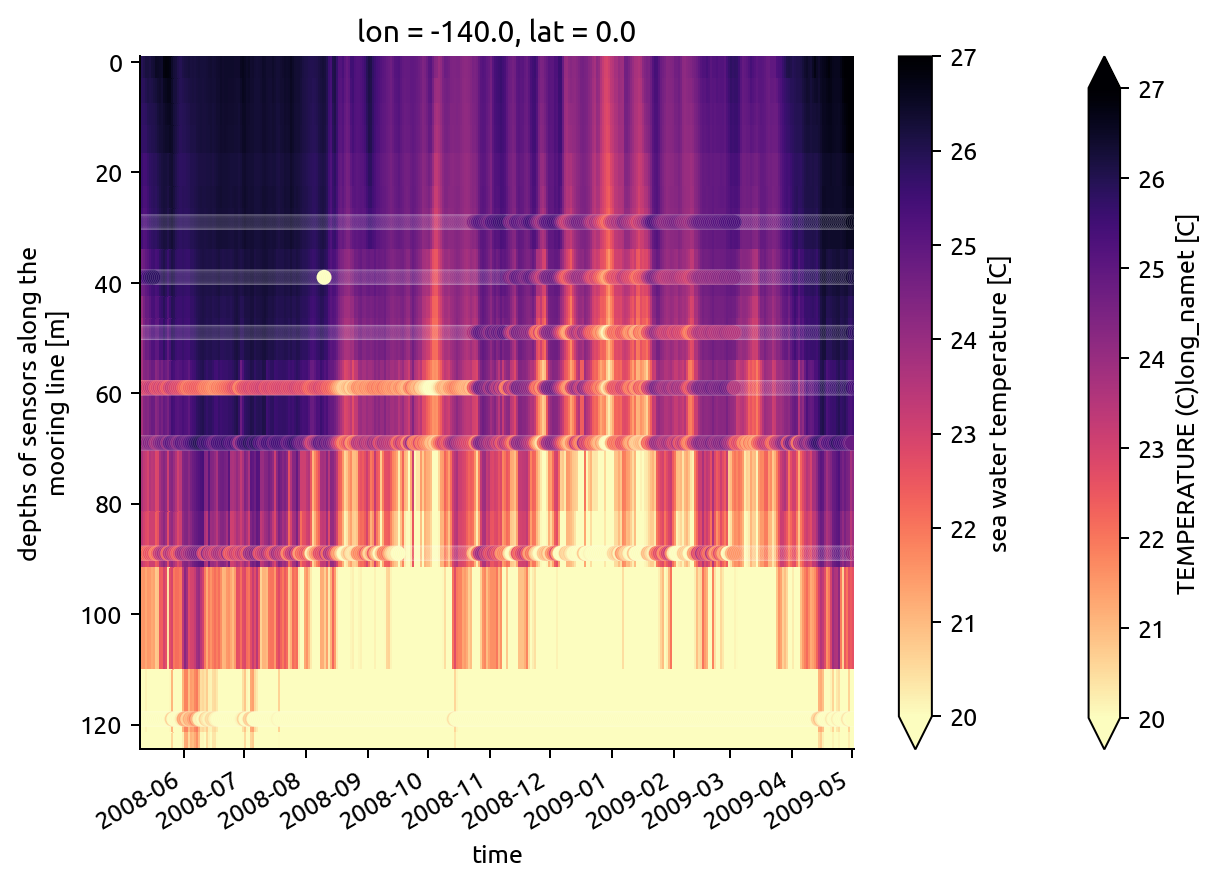

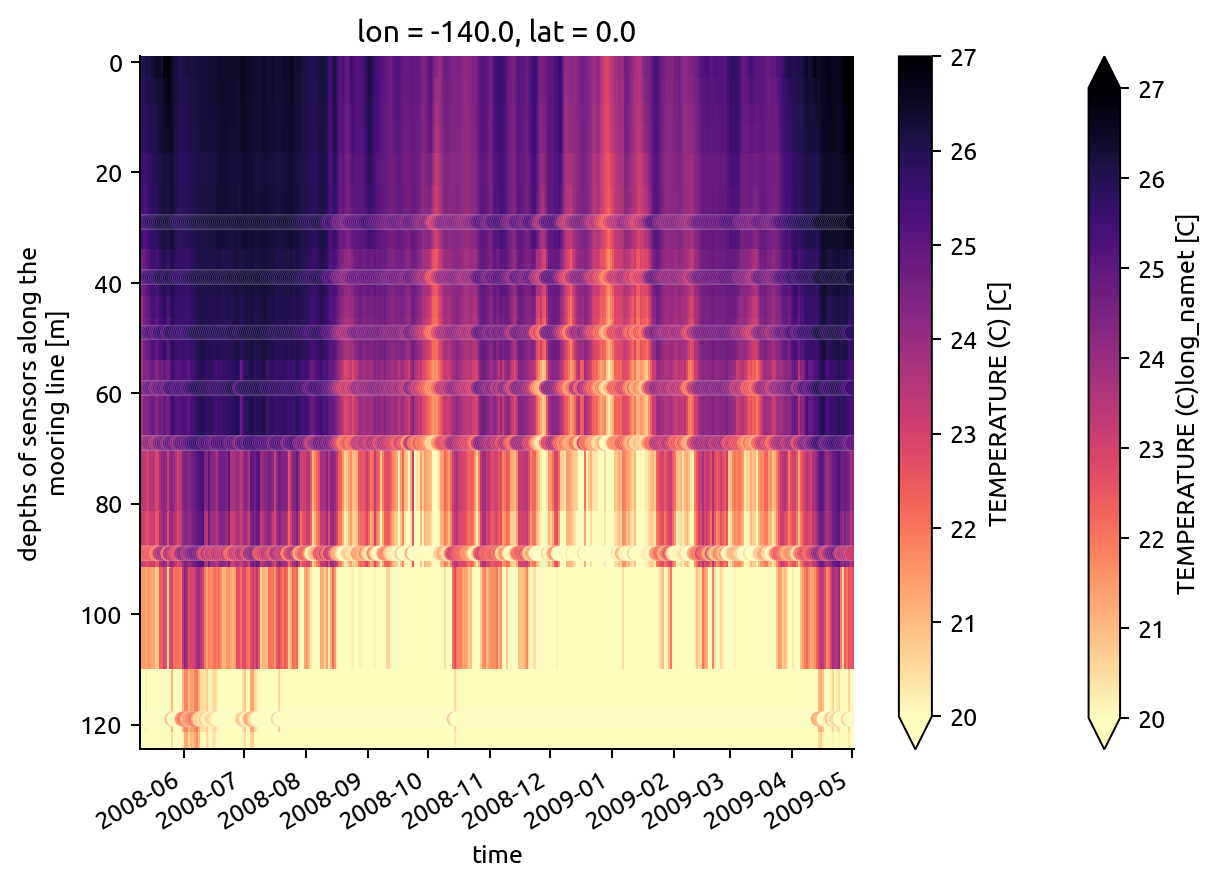

In [150]:
kwargs = dict(vmin=20, vmax=27, cmap=mpl.cm.magma_r)
taos.T.plot(robust=True, yincrease=False, **kwargs)
(
    chisub
    .resample(time="D")
    .mean()
    .plot.scatter(
        **kwargs, y="depth", x="time", hue="T_original", edgecolor="w", linewidth=0.05
    )
)

plt.figure()
taos.T.plot(robust=True, yincrease=False, **kwargs)
(
    chisub.resample(time="D")
    .mean()
    .plot.scatter(**kwargs, y="depth", x="time", hue="T", edgecolor="w", linewidth=0.05)
)

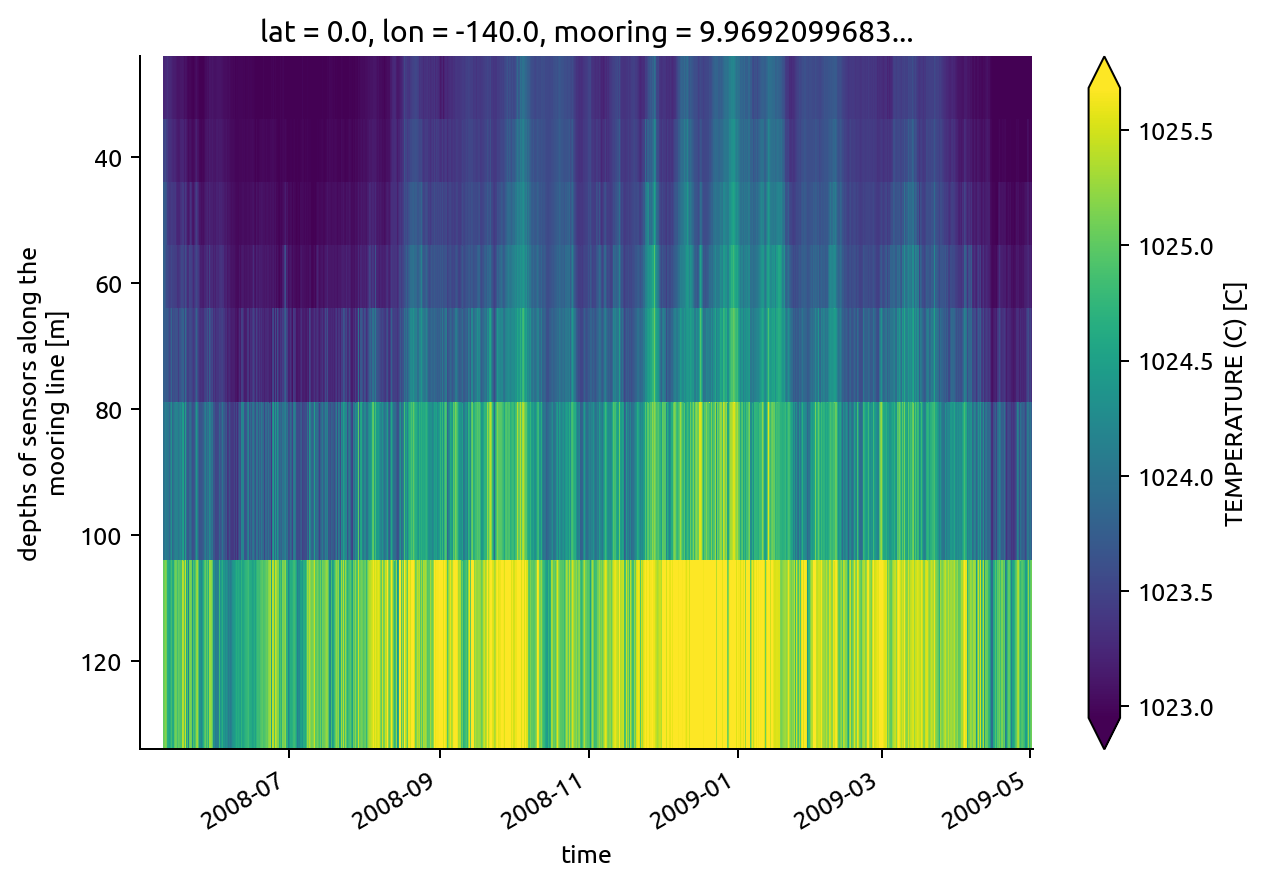

In [151]:
chisub.pden.plot(x="time", yincrease=False, robust=True)

In [3]:
obj = tao
other = chisub


def sel_like(obj, other):
    common_dims = set(obj.dims) & set(other.dims)
    return {dim: slice(other[dim][0].data, other[dim][-1].data) for dim in common_dims}


sel_like(tao, chisub)

{'depth': slice(array(29.), array(119.), None),
 'time': slice(array('2008-05-01T00:30:00.000003328', dtype='datetime64[ns]'), array('2009-05-01T23:29:59.999996672', dtype='datetime64[ns]'), None)}

---

## Read in gradients

### argo

In [152]:
argograd = xr.open_zarr(
    "../datasets/argo_monthly_iso_gradients.zarr", decode_times=False
)
argograd = argograd.cf.guess_coord_axis()
argograd.pres.attrs["positive"] = "down"
argograd = argograd.cf.add_bounds("pres")
argo = (
    argograd.sel(lon=360 + chisub.lon.item(), method="nearest")
    .sel(lat=slice(-3, 8), pres=slice(500))
    .mean("time")
)
argo["pden"] = ed.jmd95.dens(
    argo.Smean, argo.Tmean, 0 #ecco.pres.broadcast_like(ecco.Smean)
)
argo

<xarray.Dataset>
Dimensions:      (bounds: 2, lat: 11, pres: 34)
Coordinates:
  * lat          (lat) float32 -2.5 -1.5 -0.5 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5
    lon          float32 220.5
  * pres         (pres) float64 2.5 10.0 20.0 30.0 ... 420.0 440.0 462.5 500.0
    pres_bounds  (bounds, pres) float32 -1.25 6.25 15.0 ... 450.0 473.75 518.75
Dimensions without coordinates: bounds
Data variables:
    Smean        (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
    Tmean        (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dSdia        (pres, lat) float64 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dSdz         (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dSiso        (pres, lat) float64 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dTdia        (pres, lat) float64 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dTdz         (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
    dTiso        (pres, lat) float64 dask.array<chunksize=(34, 11), meta=np.ndarray>
    ρmean        (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
    pden         (pres, lat) float32 dask.array<chunksize=(34, 11), meta=np.ndarray>
Attributes:
    dataset:  argo
    name:     Mean fields and isopycnal, diapycnal gradients from Argo

/home/deepak/work/python/cf-xarray/cf_xarray/accessor.py:966: UserWarning: Variables {'pres_bounds'} not found in object but are referred to in the CF attributes.
  UserWarning,


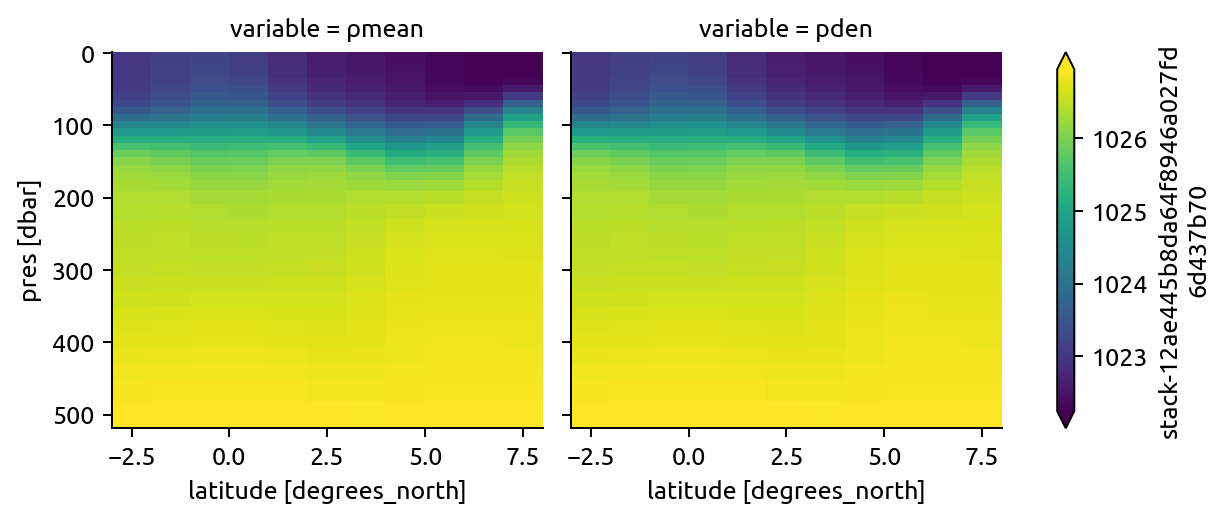

In [5]:
(
    argo[["ρmean", "pden"]]
    # .sel(lon=220, method="nearest")
    .to_array().cf.plot(col="variable", y="vertical", robust=True)
)

---
### ECCO

In [153]:
eccograd = xr.open_zarr(
    "../datasets/ecco_monthly_iso_gradients.zarr", decode_times=False
)
eccograd = eccograd.cf.guess_coord_axis()
eccograd.pres.attrs["positive"] = "down"
eccograd = eccograd.cf.add_bounds("pres")

ecco = (
    eccograd.sel(lon=360 + chisub.lon.item(), method="nearest")
    .sel(lat=slice(-3, 8), pres=slice(500))
    .mean("time")
)
ecco["pden"] = ed.jmd95.dens(
    ecco.Smean, ecco.Tmean, 0 #ecco.pres.broadcast_like(ecco.Smean)
)

/home/deepak/work/python/cf-xarray/cf_xarray/accessor.py:966: UserWarning: Variables {'pres_bounds'} not found in object but are referred to in the CF attributes.
  UserWarning,


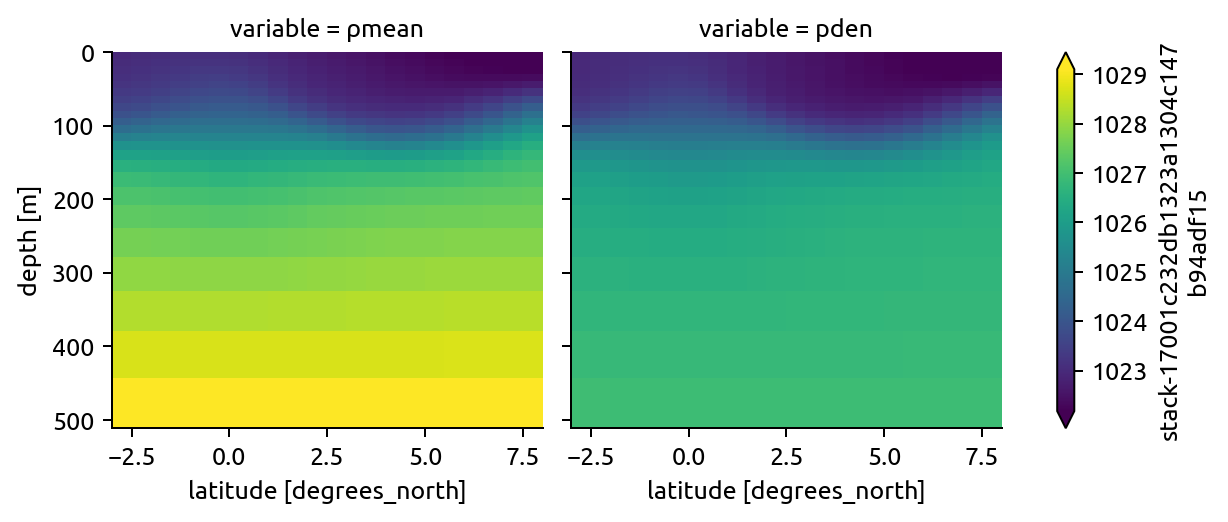

In [7]:
(
    ecco[["ρmean", "pden"]]
    # .sel(lon=220, method="nearest")
    .to_array().cf.plot(col="variable", y="vertical", robust=True)
)

---
---

## Evaluate bin choices


1. How well do ECCO & Argo agree?
1. Do the chosen ρ levels cross the mooring location? Otherwise I can't get an estimate of lateral gradient? I need the edges to cross too, so that I can get a vertical gradient
1. How do the bins look in T-S space? Am I seeing enough stirring to do the analysis

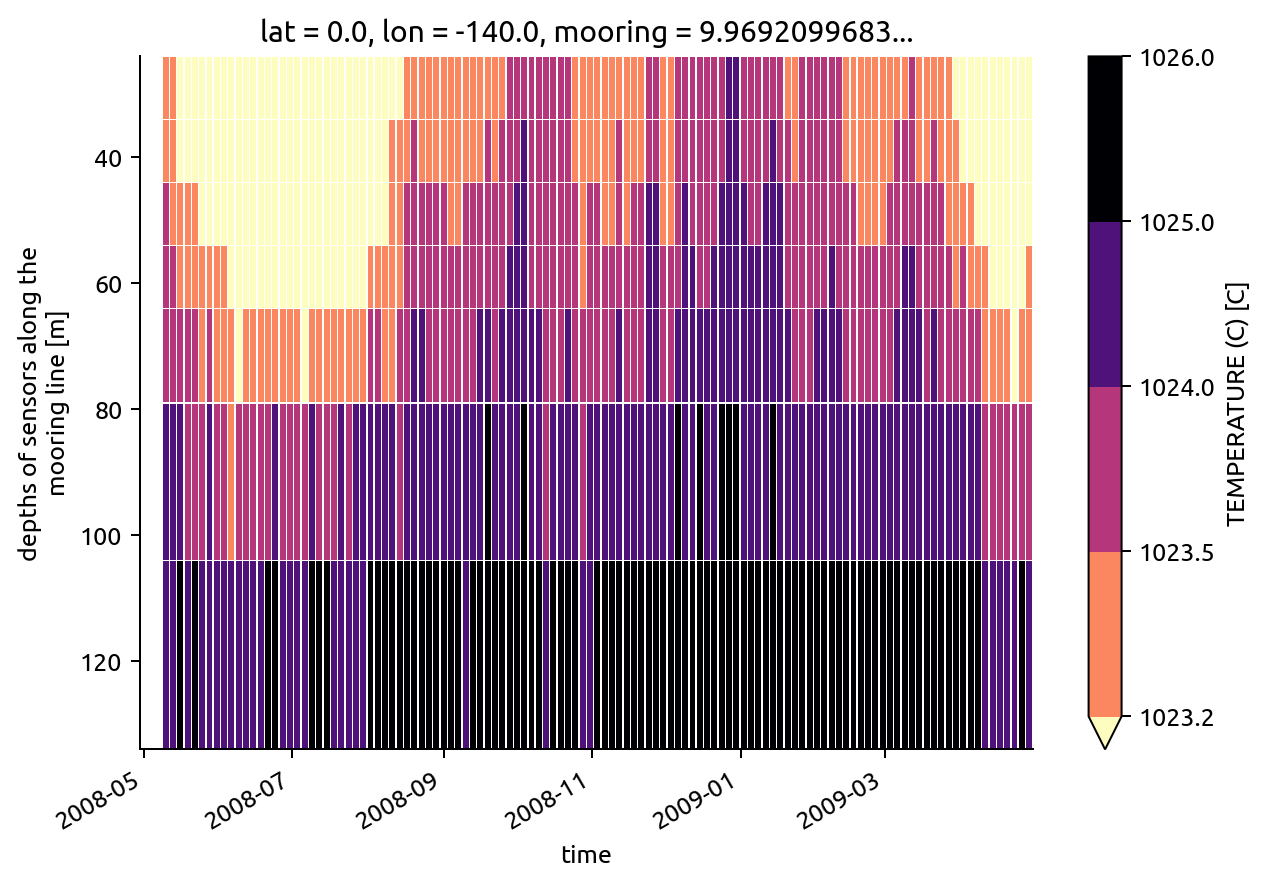

In [196]:
bins = [
    1022.5,
    1023,
    1023.5,
    1024,
    1024.5,
    1025,
    1025.5,
    1026,
    1026.5,
]
bins = np.array([1023.2, 1023.5, 1024, 1025, 1026])
centers = (bins[1:] + bins[:-1]) / 2

(
    chisub.pden.resample(time="3D")
    .mean()
    .plot(
        x="time",
        levels=bins,
        yincrease=False,
        cmap=mpl.cm.magma_r,
        edgecolor="w",
        linewidths=0.15,
    )
)

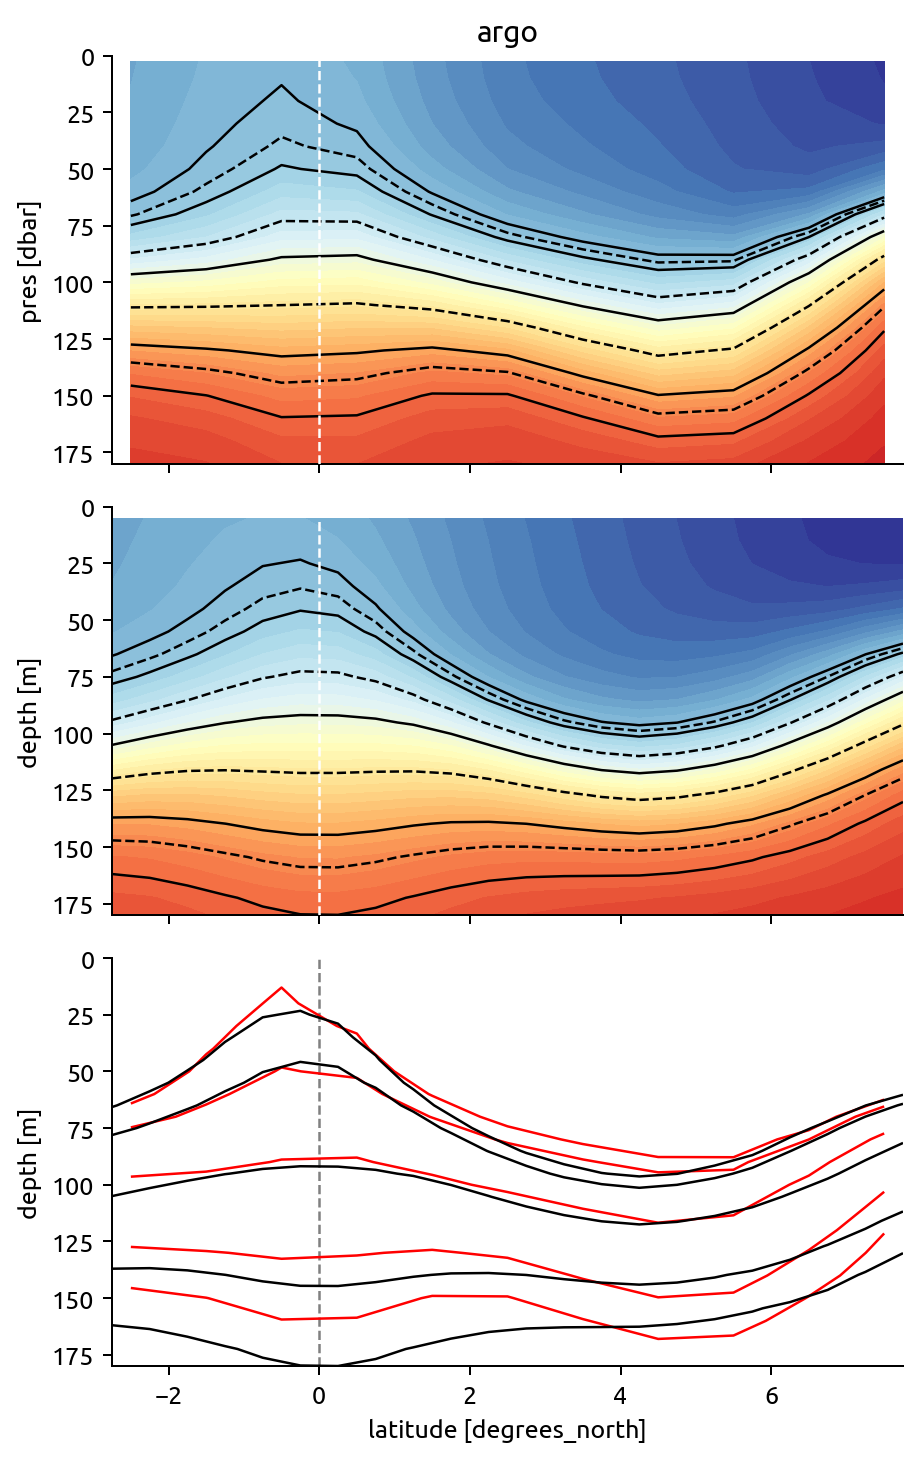

/home/deepak/miniconda3/envs/dcpy/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


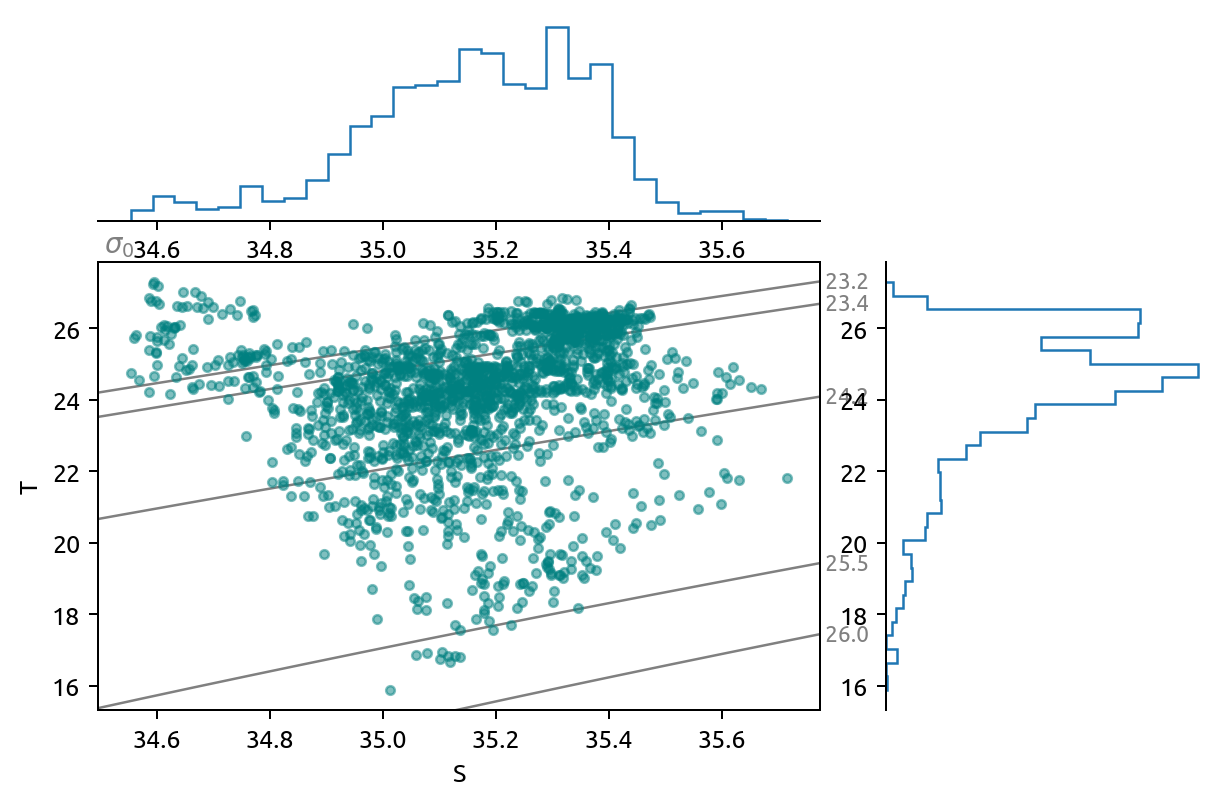

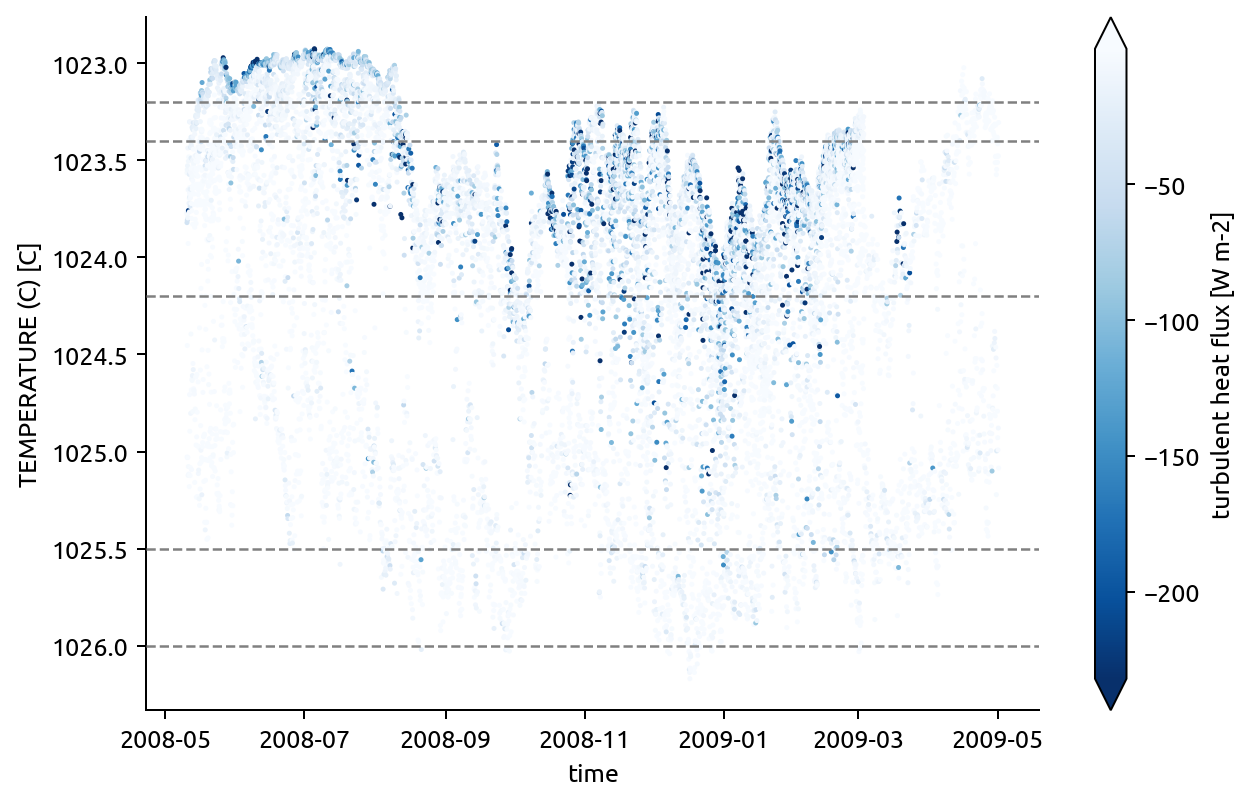

In [182]:
def debug_bins(bins):
    centers = (bins[1:] + bins[:-1]) / 2

    f, axx = plt.subplots(3, 1, sharex=True, sharey=True, constrained_layout=True, squeeze=False)

    for ds, ax in zip([argo, ecco], axx.flat):
        ds.pden.cf.plot.contourf(
            y="Z",
            ax=ax,
            levels=np.arange(1022, 1027, 0.1),
            cmap=mpl.cm.RdYlBu_r,
            add_colorbar=False,
            ylim=(200, 0),
        )
        ds.pden.cf.plot.contour(y="Z", colors="k", levels=bins, ax=ax)
        ds.pden.cf.plot.contour(
            y="Z", colors="k", linestyles="--", levels=centers, ax=ax
        )
        dcpy.plots.linex(0, zorder=10, color="w", ax=ax)
        ax.set_title(ds.dataset)
        
       
    argo.pden.plot.contour(levels=bins, colors="r", ax=axx.flat[-1])
    ecco.pden.plot.contour(levels=bins, colors="k", ylim=(180, 0),ax=axx.flat[-1])
    axx.flat[-1].legend(["argo", "ecco"])
    dcpy.plots.linex(0, ax=axx.flat[-1])

    dcpy.plots.clean_axes(axx)
    f.set_size_inches((5, 8))


debug_bins(bins)

dcpy.oceans.TSplot(
    taos.S, taos.T, rho_levels=bins, hexbin=False,
);

# chi to density space
plt.figure()
chisub.plot.scatter(
    x="time", y="pden", hue="Jq", robust=True, cmap=mpl.cm.Blues_r, s=1
)
plt.gca().yaxis.set_inverted(True)
if "bins" in locals():
    dcpy.plots.liney(bins, zorder=10)

---

## Estimate gradients

The magnitudes of ∂T/∂y seem to agree to within a factor of 2. Though the latitudinal profile of these gradients looks quite different (argo vs ecco)

The spline fits to the Argo data seems a little "stiff". Maybe I need to play with some parameters

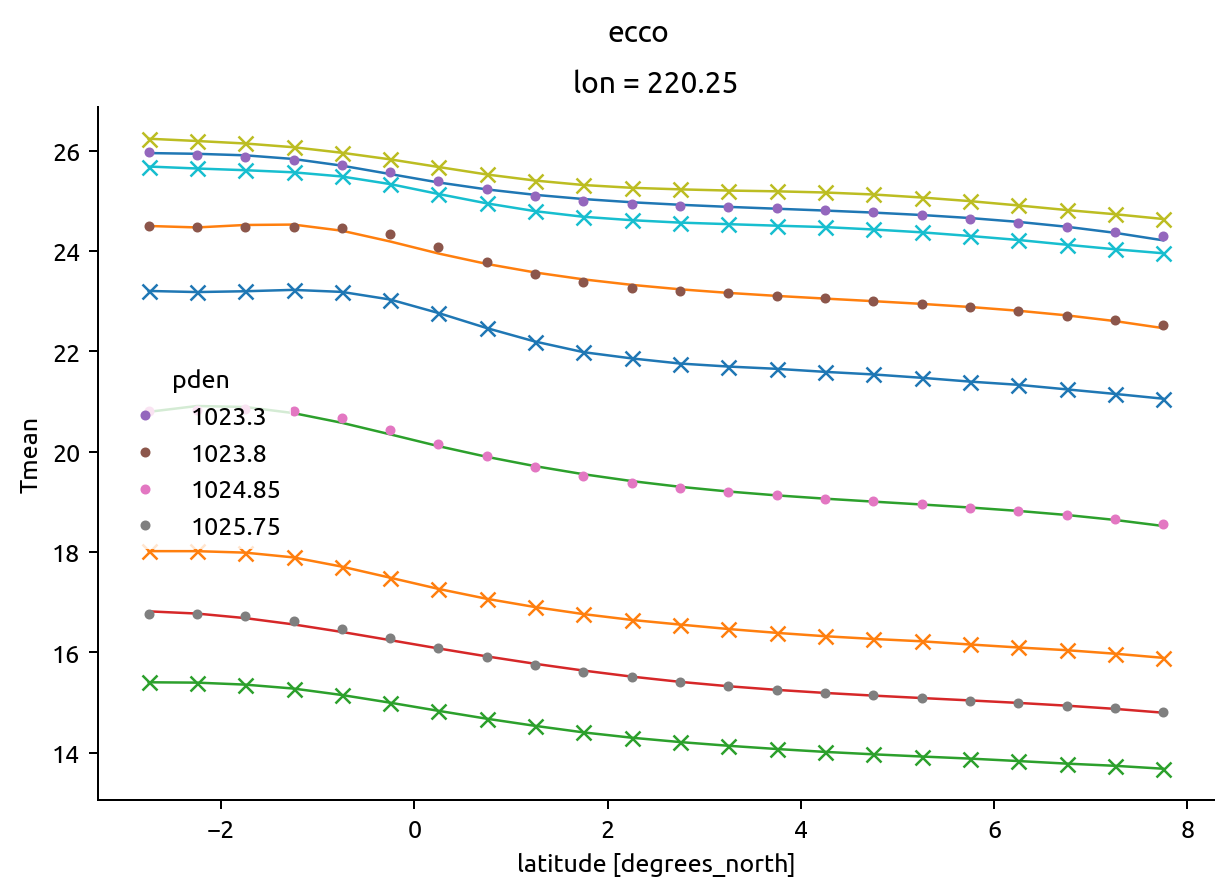

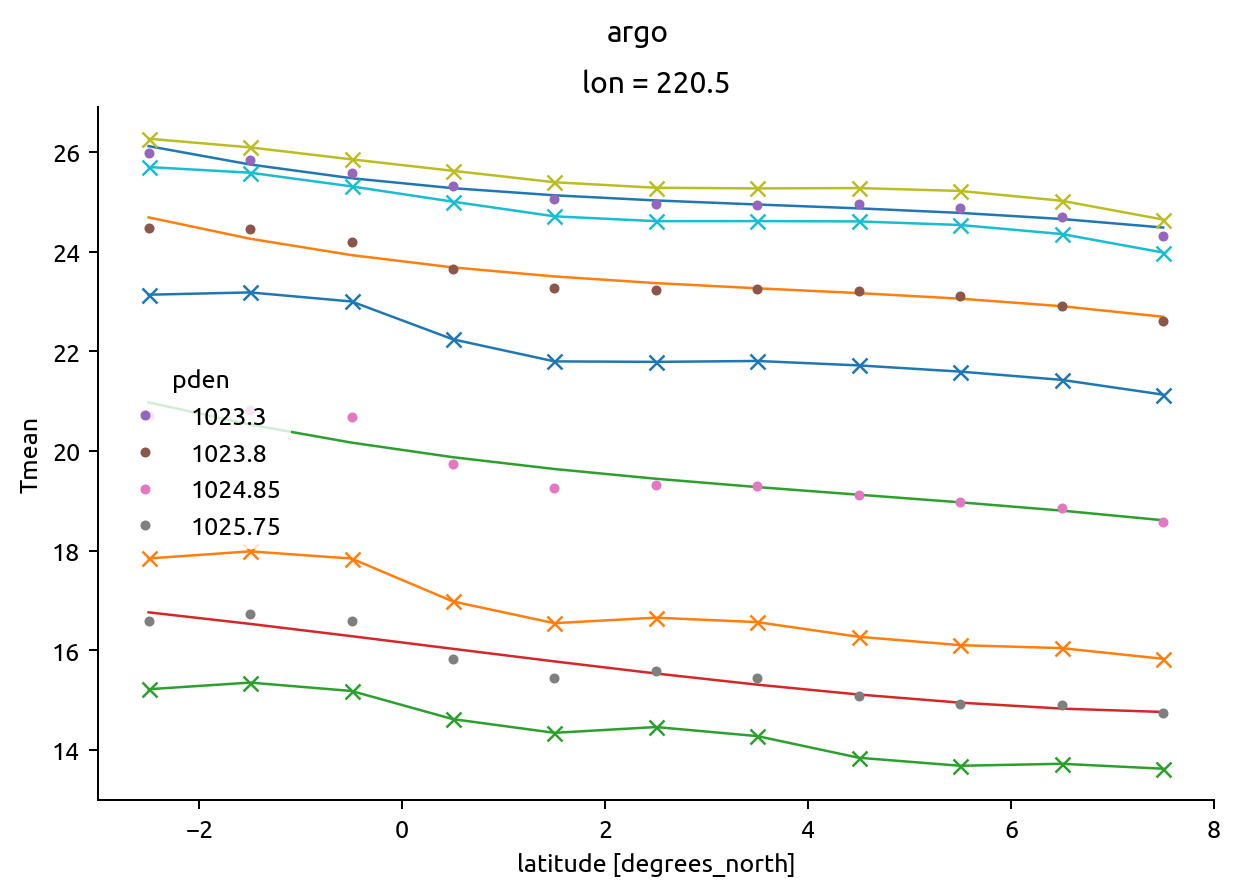

In [183]:
def estimate_gradients(grad, bins, debug=False):
    """
    Estimates the isopycnal and vertical gradients of temperature

    Parameters
    ----------

    grad: Dataset
        Climatological fields with temperature
    bins: np.array
        Isopycnal bin edges

    Returns
    -------

    Dataset with ``dTdy`` and ``dTdz``

    Notes
    -----

    Procedure:
      - First conservatively regrids T to isopycnal space using bin averages
      - Then fits univariate spline to mean T in each isopycnal bin
      - Estimates ∂T/∂y using this spline fit.
      - ∂T/∂z is estimated using the mean separation between isopycnal bin edges
        (product of the isopycnal regridding code)
    """
    bins = np.asarray(bins)
    centers = (bins[1:] + bins[:-1]) / 2

    grid = xgcm.Grid(
        grad, periodic=False, coords={"Y": {"center": "lat"}, "Z": {"center": "pres"}}
    )

    # isoT = ed.regrid_to_isopycnals(grad, bins).rename({"pden_bins": "pden"})
    
    if np.any(bins < 1000):
        raise ValueError(f"bins={bins} < 1000")

    isoT = xr.Dataset()
    isoT["Tmean"] = grid.transform(
        grad.Tmean,
        "Z",
        target=centers,
        target_data=grad.pden,
        method="linear",
    ).compute()

    z_regrid = grid.transform(
        grad.pres.broadcast_like(grad.pden),
        "Z",
        target=bins,
        target_data=grad.pden,
        method="linear",
    ).compute()

    # calculate the layer thickness of the new coord bounds
    isoT.coords["dz_remapped"] = z_regrid.diff("pden").drop_vars("pden")

    # get isopycnal gradients of T by fitting spline
    # to average T in density bins
    isoT.coords["y"] = dcpy.util.latlon_to_distance(
        isoT.cf["latitude"], isoT.cf["longitude"], central_lat=0, central_lon=isoT.lon.item()
    ) * np.sign(isoT.lat)
    isoT.y.attrs["axis"] = "Y"

    sub = isoT.Tmean.chunk({"lat": -1}).swap_dims({"lat": "y"})
    spinterp = dcpy.interpolate.UnivariateSpline(sub, "y")

    isoT["dTdy"] = spinterp.derivative(sub.y).swap_dims({"y": "lat"}).compute()

    if debug:
        plt.figure()
        spinterp.smooth().compute().plot.line(x="lat", hue="pden", add_legend=False)
        sub.plot.line(x="lat", hue="pden", marker=".", ls="none", add_legend=True)
        plt.suptitle(grad.attrs["dataset"])

    # regrid to the bin edges
    edgeT = (
        grid.transform(
            grad.Tmean, "Z", target=bins, target_data=grad.pden, method="linear"
        ).compute()
        # ed.regrid_to_isopycnals(grad, bins, "centers")
        # .load()
        # .assign_coords(pden_bins=centers[:-1])
        # .reindex_like(isoT, method="nearest")
        # .assign_coords(pden_bins=centers)
    )

    isoT["dTdz"] = (
        -1
        * edgeT.diff("pden").assign_coords(pden=isoT.pden.values)
        / isoT.dz_remapped.compute()
    )
    # isoT["dTdz"] = -1 * isoT.Tmean.diff("pden_bins") / isoT.dz_remapped
    if debug:
        hdl = edgeT.plot.line(marker="x", hue="pden", add_legend=False)
        # plt.gca().legend(hdl)

    return isoT, edgeT


eccoT, edge = estimate_gradients(ecco, bins, debug=True)
argoT, edge = estimate_gradients(argo, bins, debug=True)

### Horizontal gradient

<Figure size 1440x900 with 0 Axes>

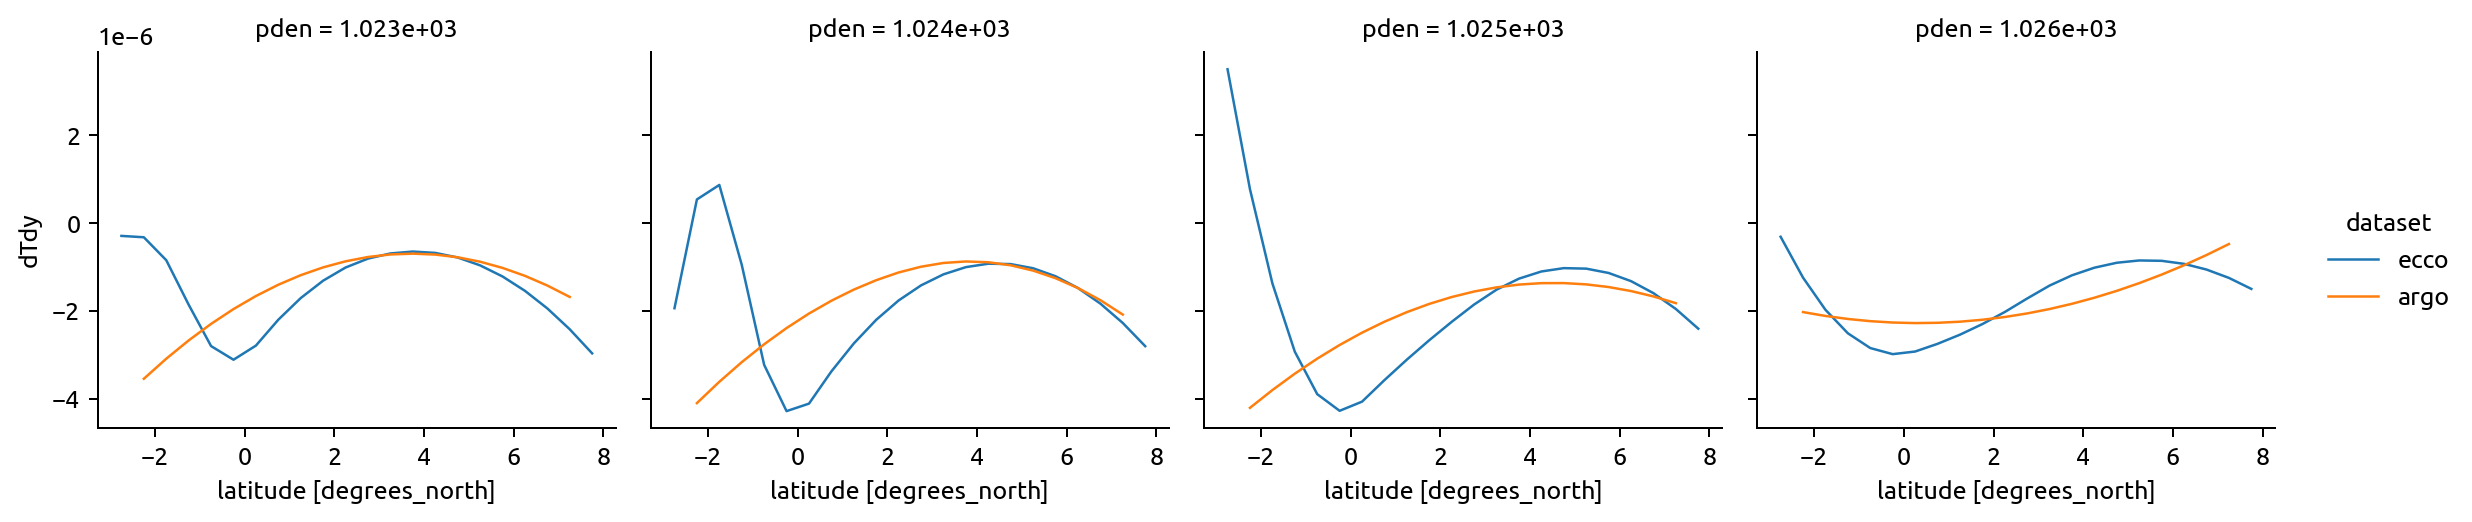

In [184]:
plt.figure()
xr.concat([eccoT.dTdy, argoT.dTdy.interp(lat=eccoT.lat)], dim=["ecco", "argo"]).rename(
    {"concat_dim": "dataset"}
).plot.line(x="lat", col="pden", hue="dataset")

### debugging plots

In [11]:
ed.fit_spline(isoT.lat, isoT.Tmean.isel(ρmean_bins=10).values, debug=True)

NameError: name 'isoT' is not defined

In [ ]:
eccograd.Tmean.sel(lon=slice(200, 240), lat=slice(-10, 10), pres=slice(150)).sel(
    lon=220, lat=0, method="nearest"
).plot(x="time", ylim=(200, 0), robust=True)
eccograd.ρmean.sel(lon=slice(200, 240), lat=slice(-10, 10), pres=slice(150)).sel(
    lon=220, lat=0, method="nearest"
).plot.contour(levels=11, x="time", ylim=(200, 0), robust=True)

In [ ]:
eccograd.dTdz.sel(lat=slice(-10, 10), lon=slice(200, 240)).sel(
    pres=100, method="nearest"
).isel(time=0).plot()

In [ ]:
eccograd.dTiso.sel(lat=slice(-10, 10), lon=slice(200, 240)).sel(
    pres=100, method="nearest"
).isel(time=0).plot()

---
---

### Vertical gradient


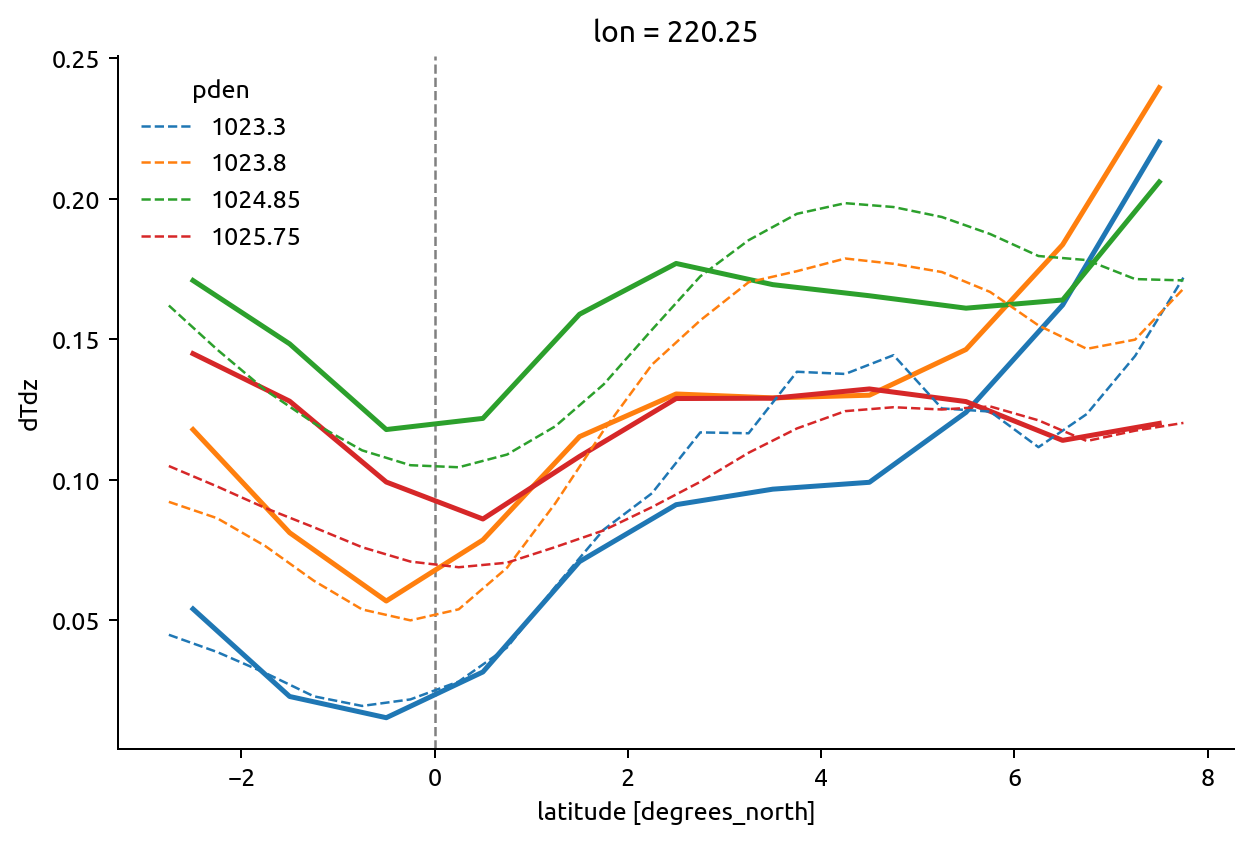

In [185]:
plt.rcParams["figure.dpi"] = 180

from cycler import cycler

cycle = plt.rcParams["axes.prop_cycle"]
with plt.rc_context({"axes.prop_cycle": cycler(color=cycle[:4])}):
    argoT.dTdz.plot.line(x="lat", lw=2)
    eccoT.dTdz.plot.line(x="lat", ls="--")
    dcpy.plots.linex(0)

---
---

## Compare dTdz between mean field and mooring

/home/deepak/work/python/cf-xarray/cf_xarray/accessor.py:966: UserWarning: Variables {'pres_bounds'} not found in object but are referred to in the CF attributes.
  UserWarning,
/home/deepak/work/python/cf-xarray/cf_xarray/accessor.py:966: UserWarning: Variables {'pres_bounds'} not found in object but are referred to in the CF attributes.
  UserWarning,


[None, None]

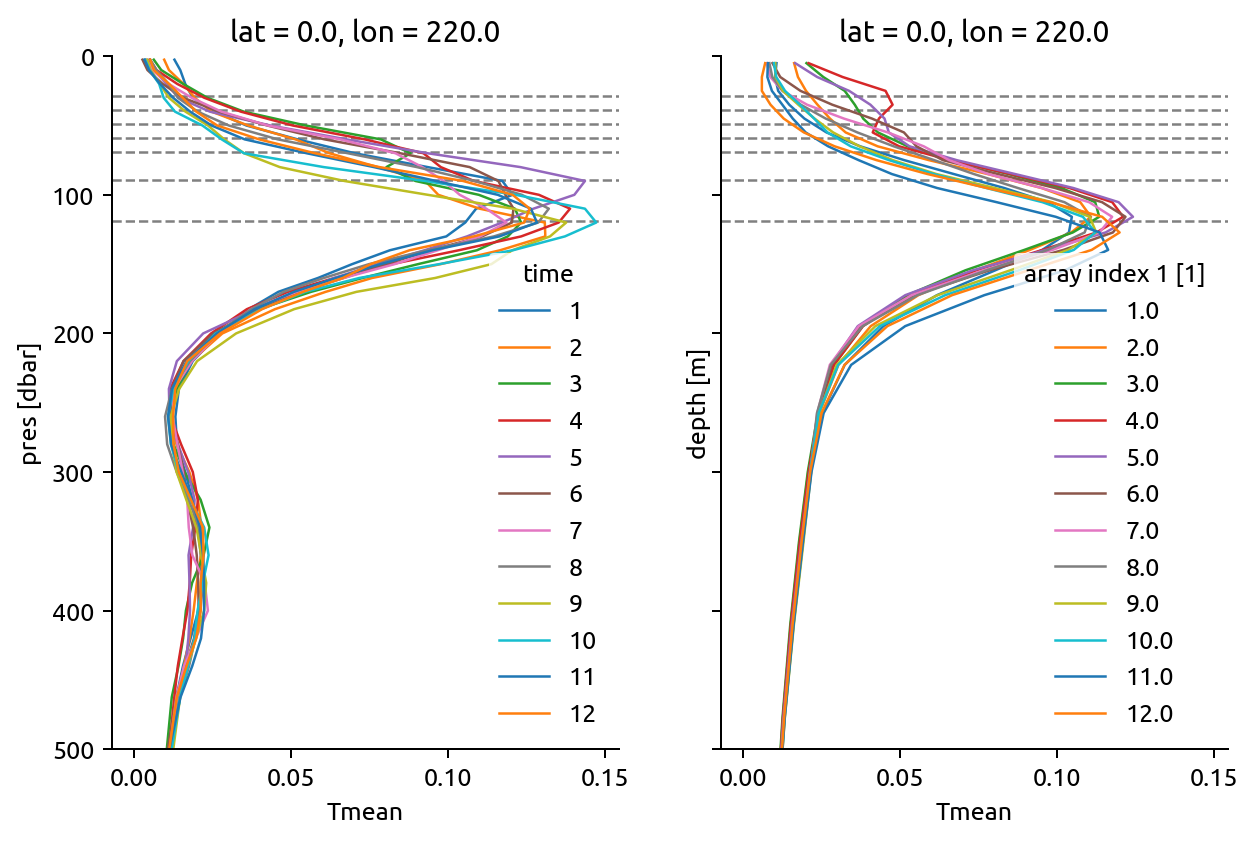

In [186]:
f, ax = plt.subplots(1, 2, sharex=True, sharey=True)
(
    (-1 * argograd.Tmean.interp(lat=chisub.lat.values, lon=360 + chisub.lon.values))
    .differentiate("pres")
    .cf.plot(y="Z", ylim=(500, 0), hue="time", ax=ax[0])
)


(
    (-1 * eccograd.Tmean.interp(lat=chisub.lat.values, lon=360 + chisub.lon.values))
    .differentiate("pres")
    .cf.plot(y="Z", ylim=(500, 0), hue="time", ax=ax[1])
)

[dcpy.plots.liney(chisub.depth, ax=aa) for aa in ax]

# eccoT["dTdz"].sel(lat=0, method="nearest").plot(y="z")

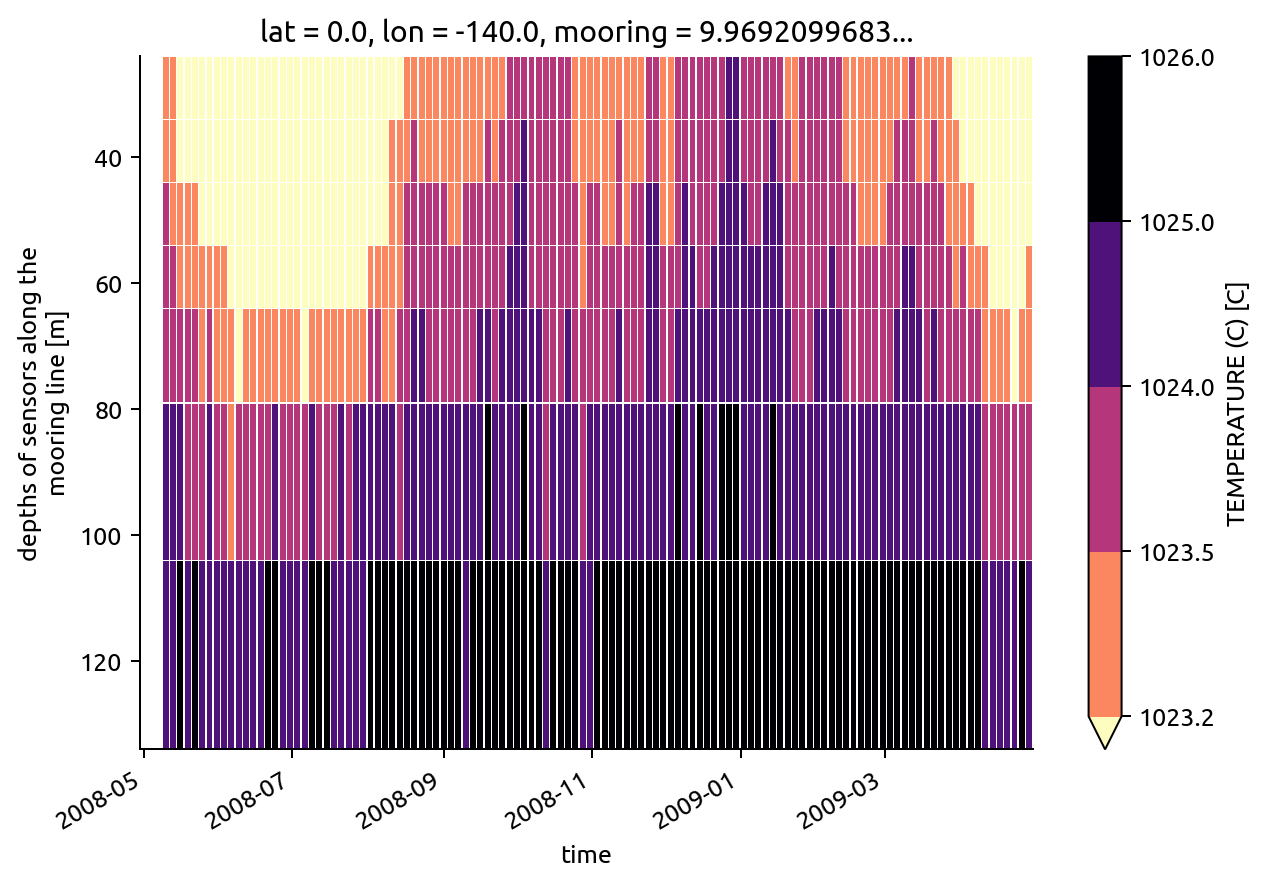

In [196]:
bins = [
    1022.5,
    1023,
    1023.5,
    1024,
    1024.5,
    1025,
    1025.5,
    1026,
    1026.5,
]
bins = np.array([1023.2, 1023.5, 1024, 1025, 1026])
centers = (bins[1:] + bins[:-1]) / 2

(
    chisub.pden.resample(time="3D")
    .mean()
    .plot(
        x="time",
        levels=bins,
        yincrease=False,
        cmap=mpl.cm.magma_r,
        edgecolor="w",
        linewidths=0.15,
    )
)

---
---

## Do estimate

In [206]:
chidf = (
    chisub #.sel(depth=slice(39, None))  # TODO: wintertime MLD?
    .where(chisub.KT < 1e-3)
    .resample(time="D")
    .mean()
    .compute()
    .to_dataframe()
    .dropna()
)

In [202]:
# TODO: move this to ed.bin_to_density_space
def bin_avg_in_density_time(df, ρbins, strftime="%Y-%m"):
    """
    Takes input dataframe for transect, bins each profile by density
    and averages. Returns average data as function of transect distance,
    mean density in bin.
    """

    df = df.reset_index()
    time_grouper = df.time.dt.strftime(strftime)

    grouped = df.groupby([pd.cut(df.pden, ρbins), time_grouper])

    result = grouped.mean()
    result["numobs"] = grouped.size()
    result = result.dropna(how="any").drop("pden", axis=1).reset_index()
    result["time"] = pd.to_datetime(result["time"])

    return result.set_index(["pden", "time"])

binned = bin_avg_in_density_time(chidf, bins).drop(
    ["timeSeries", "lat", "lon", "mooring", "chipod", "crs"],
    axis=1,
    errors="ignore",
)
pdentime = binned.index.to_frame()
midpoints = pd.Series([v.mid for v in pdentime["pden"].values], name="pden")
newindex = pd.MultiIndex.from_arrays([midpoints, pdentime["time"]])
float_indexed = binned.set_index(newindex)
chidens = xr.Dataset.from_dataframe(float_indexed)
chidens = chidens.rename({"pden": "pden"})

chidens["chi"].attrs["long_name"] = "$χ$"
chidens["KtTz"].attrs["long_name"] = "$⟨K_T T_z⟩$"
chidens

<xarray.Dataset>
Dimensions:     (pden: 4, time: 13)
Coordinates:
  * pden        (pden) float64 1.023e+03 1.024e+03 1.024e+03 1.026e+03
  * time        (time) datetime64[ns] 2008-05-01 2008-06-01 ... 2009-05-01
Data variables:
    depth       (pden, time) float64 62.0 69.0 69.0 63.0 ... 119.0 119.0 nan
    T_original  (pden, time) float64 23.52 24.56 25.29 23.41 ... 17.32 17.92 nan
    dTdz        (pden, time) float64 0.04488 0.06119 0.07298 ... 0.1247 nan
    N2          (pden, time) float64 0.0001253 0.0001575 ... 0.0002878 nan
    KT          (pden, time) float64 7.905e-05 4.81e-05 ... 0.0001004 nan
    chi         (pden, time) float64 1.539e-07 2.496e-07 ... 3.502e-08 nan
    eps         (pden, time) float64 2.485e-08 2.838e-08 ... 7.56e-09 nan
    Jq          (pden, time) float64 -6.771 -7.973 -24.03 ... -2.444 -2.053 nan
    KtTz        (pden, time) float64 3.278e-06 2.792e-06 ... 1.301e-05 nan
    T           (pden, time) float64 24.93 25.0 25.1 24.91 ... 17.64 18.38 nan
    numobs      (pden, time) float64 20.0 33.0 23.0 20.0 ... 28.0 31.0 13.0 nan

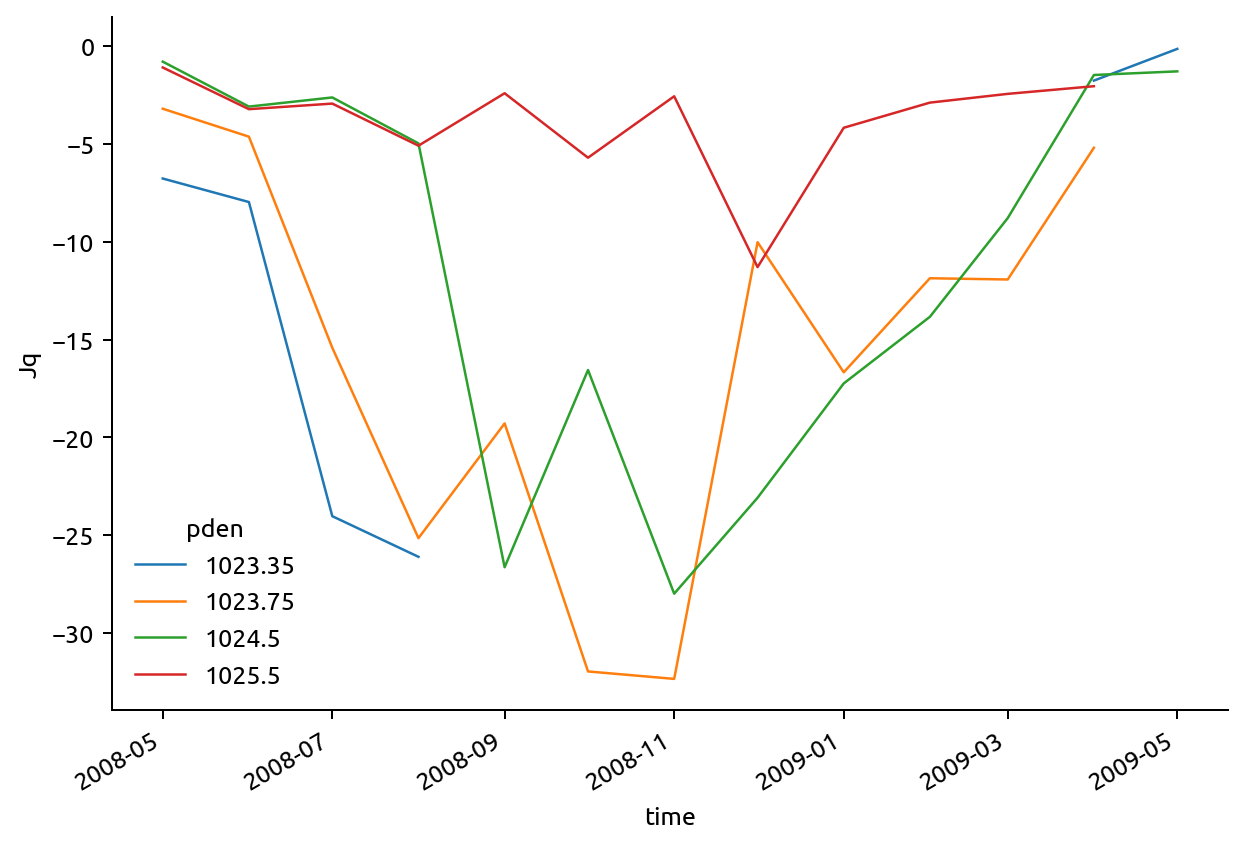

In [203]:
%matplotlib inline

chidens.Jq.plot.line(hue="pden")

AttributeError: 'numpy.ndarray' object has no attribute 'mid'

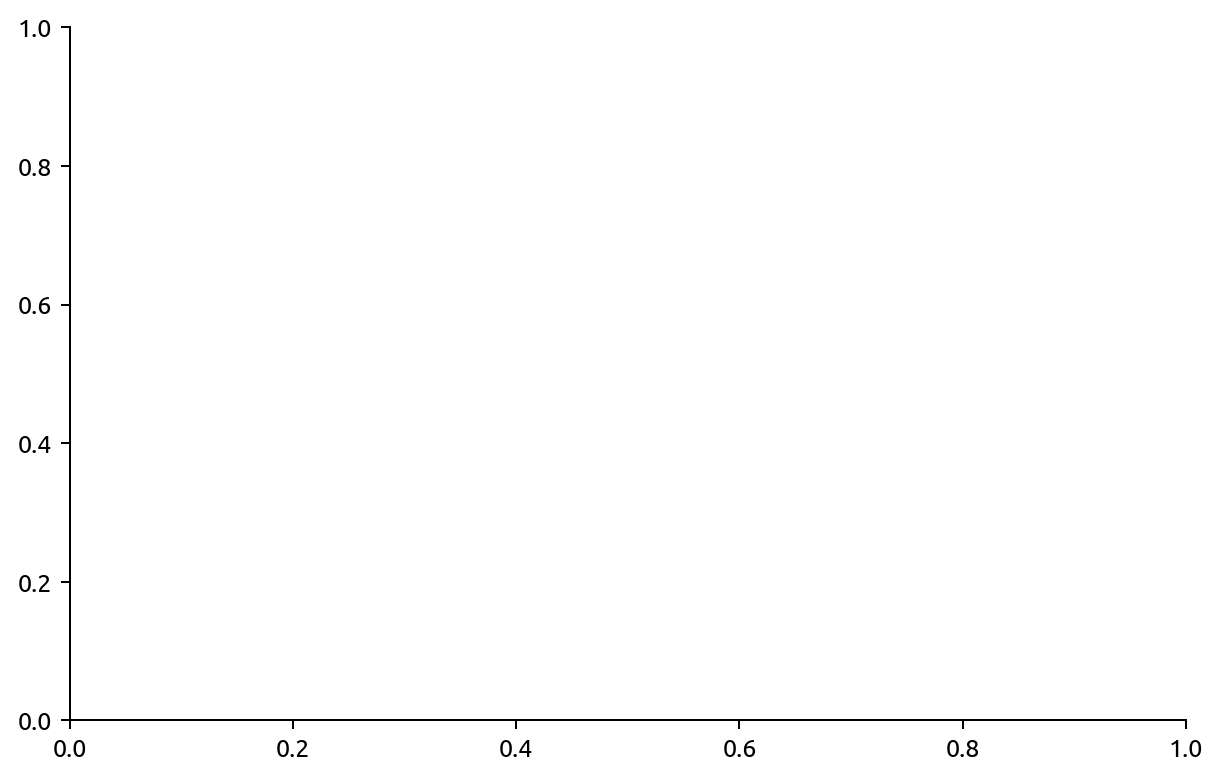

In [204]:
%matplotlib inline

isoT = eccoT.interp(lat=0)

Ke = (chidens["chi"] / 2 - (chidens["KtTz"] * isoT["dTdz"])) / (isoT["dTdy"] ** 2)
Ke.plot.line(hue="pden")
dcpy.plots.liney(0)

### Debugging estimate

1. Seasonal cycle in 'inverse" $T_z$ estimated as $⟨χ/2⟩ / ⟨K_T T_z⟩$
2. Negative $K_e$ values are where the annual mean gradient in climatology is larger than the "inverse" $T_z$
3. $⟨T^χ_z⟩$ from χpods averaged in density space is always larger than the other two estimates

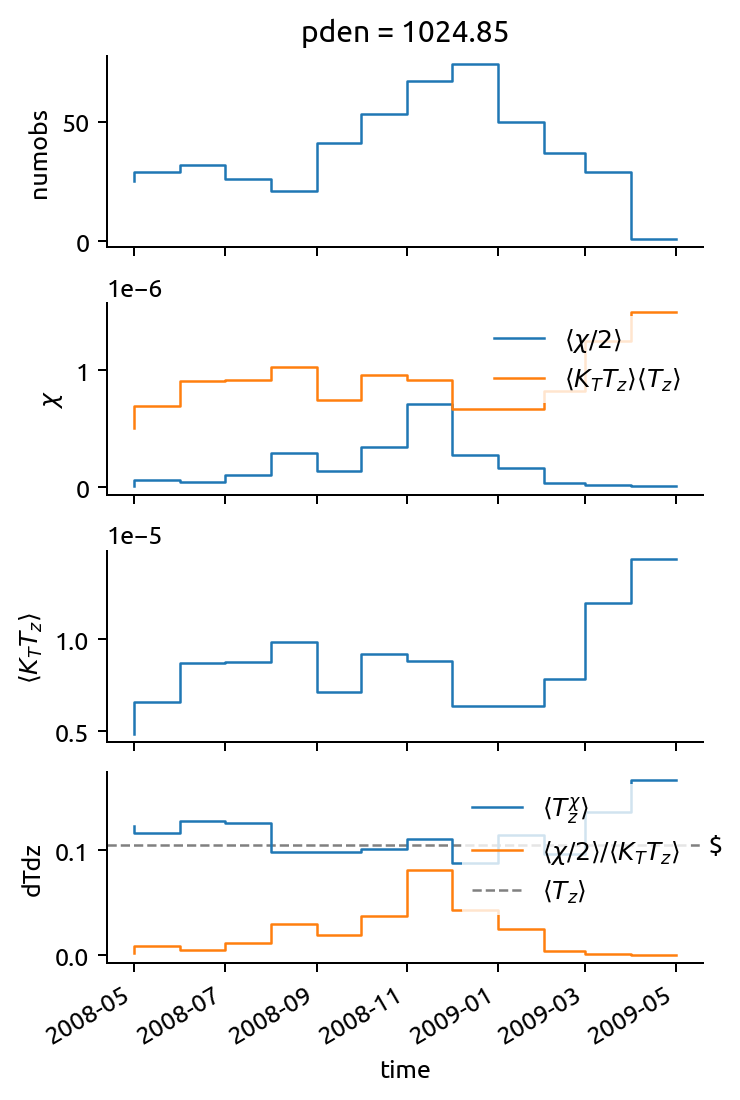

In [193]:
%matplotlib inline

est = chidens.isel(pden=2)
isoTz = isoT.dTdz.isel(pden=2)

f, axx = plt.subplots(
    4,
    1,
    sharex=True,
    sharey=False,
    squeeze=False,
    constrained_layout=True,
    figsize=(4, 6),
)
ax = dict(zip(["count", "chi", "KtTz", "Tz"], axx.flat))

(est["numobs"]).plot.step(ax=ax["count"])
(est.chi / 2).plot.step(ax=ax["chi"], label="$⟨χ/2⟩$")
(est.KtTz * isoTz).plot.step(ax=ax["chi"], label="$⟨K_T T_z⟩ ⟨T_z⟩$", _labels=False)
ax["chi"].legend()
# (est.KtTz * est.dTdz).plot(ax=ax["chi"])

(est.KtTz).plot.step(ax=ax["KtTz"])

(est.dTdz).plot.step(ax=ax["Tz"], label="$⟨T^χ_z⟩$")
(est.chi / 2 / est.KtTz).plot.step(
    ax=ax["Tz"], label="$⟨χ/2⟩ / ⟨K_T T_z⟩$", _labels=False
)
dcpy.plots.liney(isoTz, ax=ax["Tz"], label="$⟨T_z⟩$")
ax["Tz"].legend()
dcpy.plots.clean_axes(axx)

The "seasonal" cycle in $T_z$ is funny. There are more observations being averaged over and those observations are at 30,40,50m.

I thought it is an artifact. BUT what if there is a seasonal cycle in $T_z$ in in the isopycnal bins.

In depth space, $T_z$ increases with depth, so if the isopycnal surface shallows for two months (DJF here), "effective" dT/dz is smaller than our climatological estimate. This ends up being negative $K_e$

I think this is being ignored in the equations. Maybe this is advection at "eddy" timescales that is changing $T_z$ at the "eddy" timescale

Manually excluding everything above 59m improves things a bunch.

Things that may help:
1. Choose bins to avoid this by looking at plots?
2. add a diagnostic that checks for scatter in $T_z$ in chosen bins. This could help with 1.
3. Explicitly account for this as a source of variance?

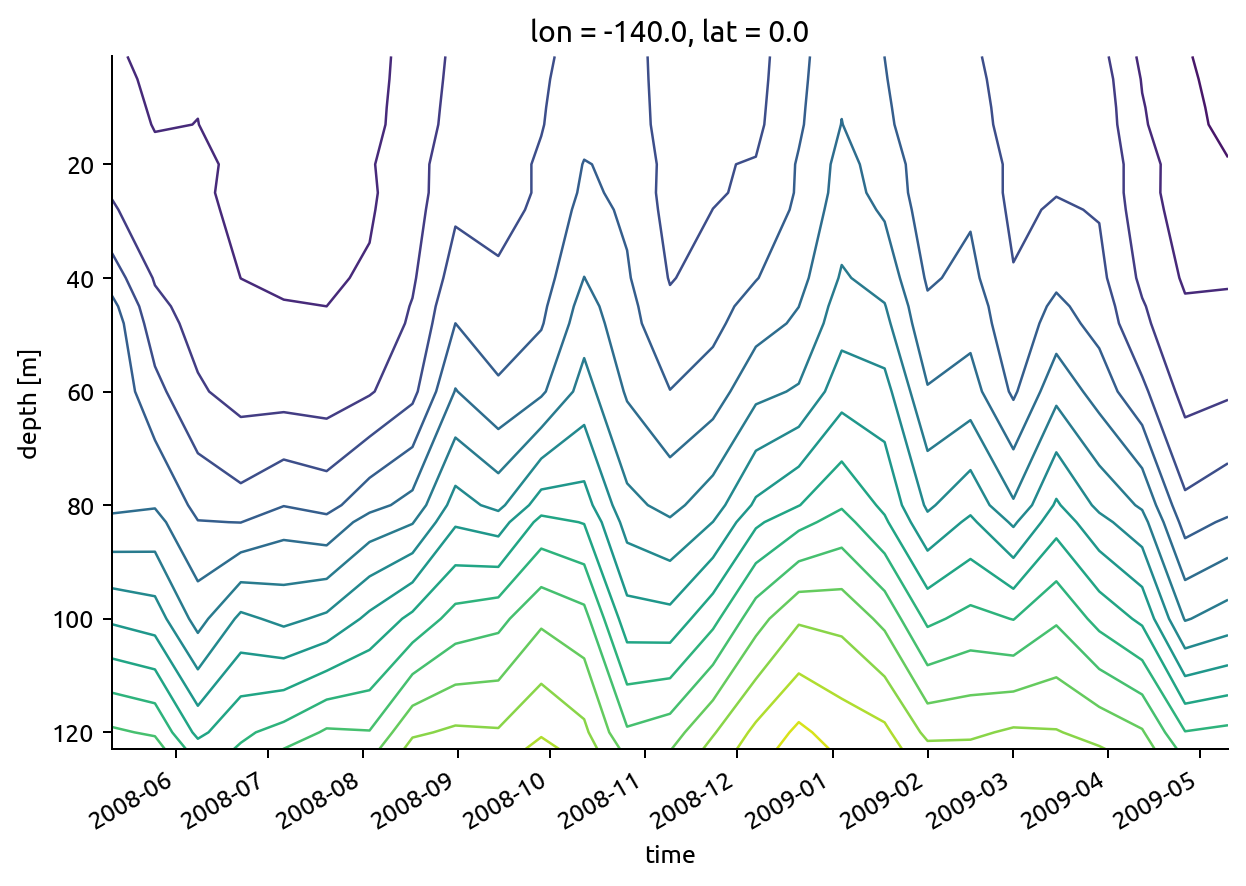

In [174]:
taos.rhoT.resample(time="2W").mean().plot.contour(levels=20, yincrease=False)

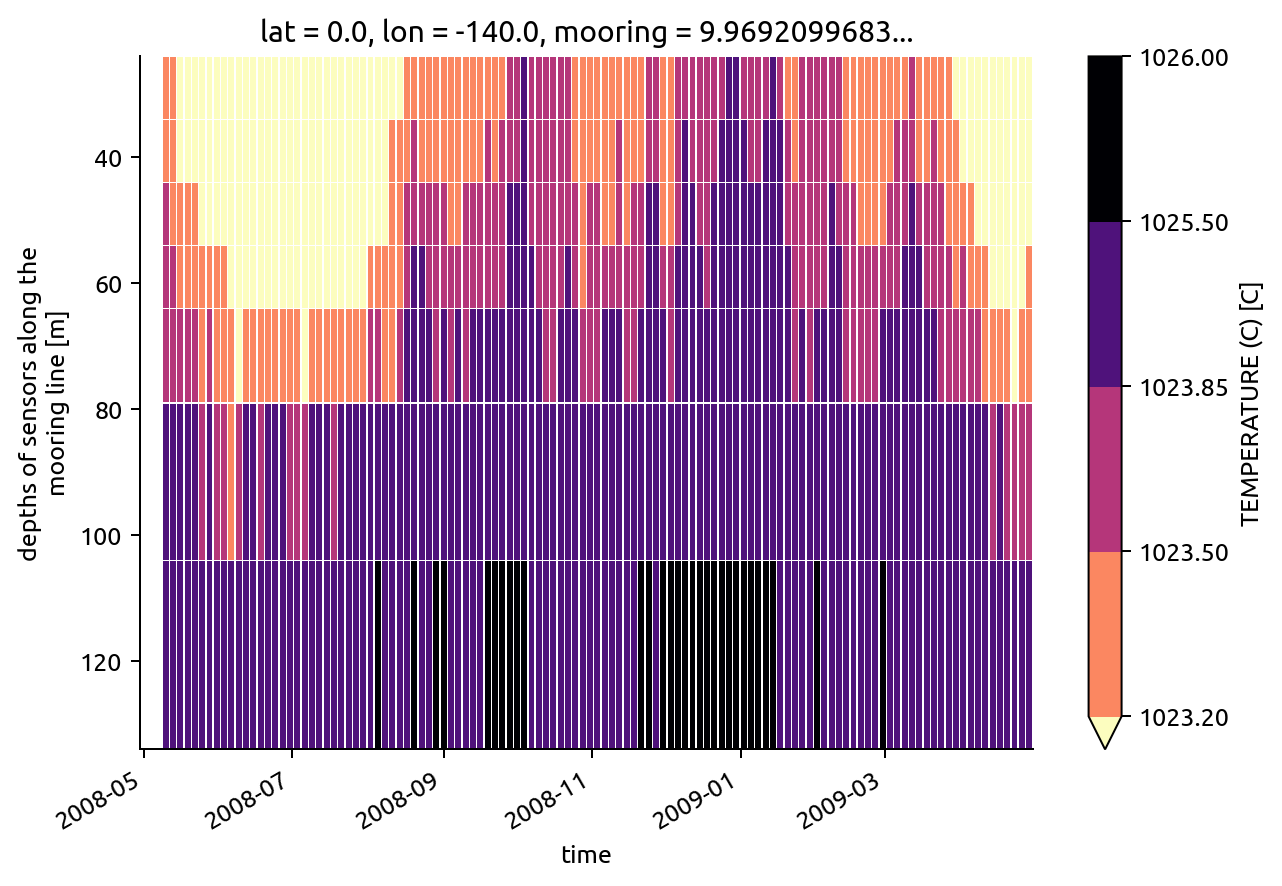

In [167]:
(
    chisub.pden.resample(time="3D")
    .mean()
    .plot(
        x="time",
        levels=bins,
        yincrease=False,
        cmap=mpl.cm.magma_r,
        edgecolor="w",
        linewidths=0.15,
    )
)

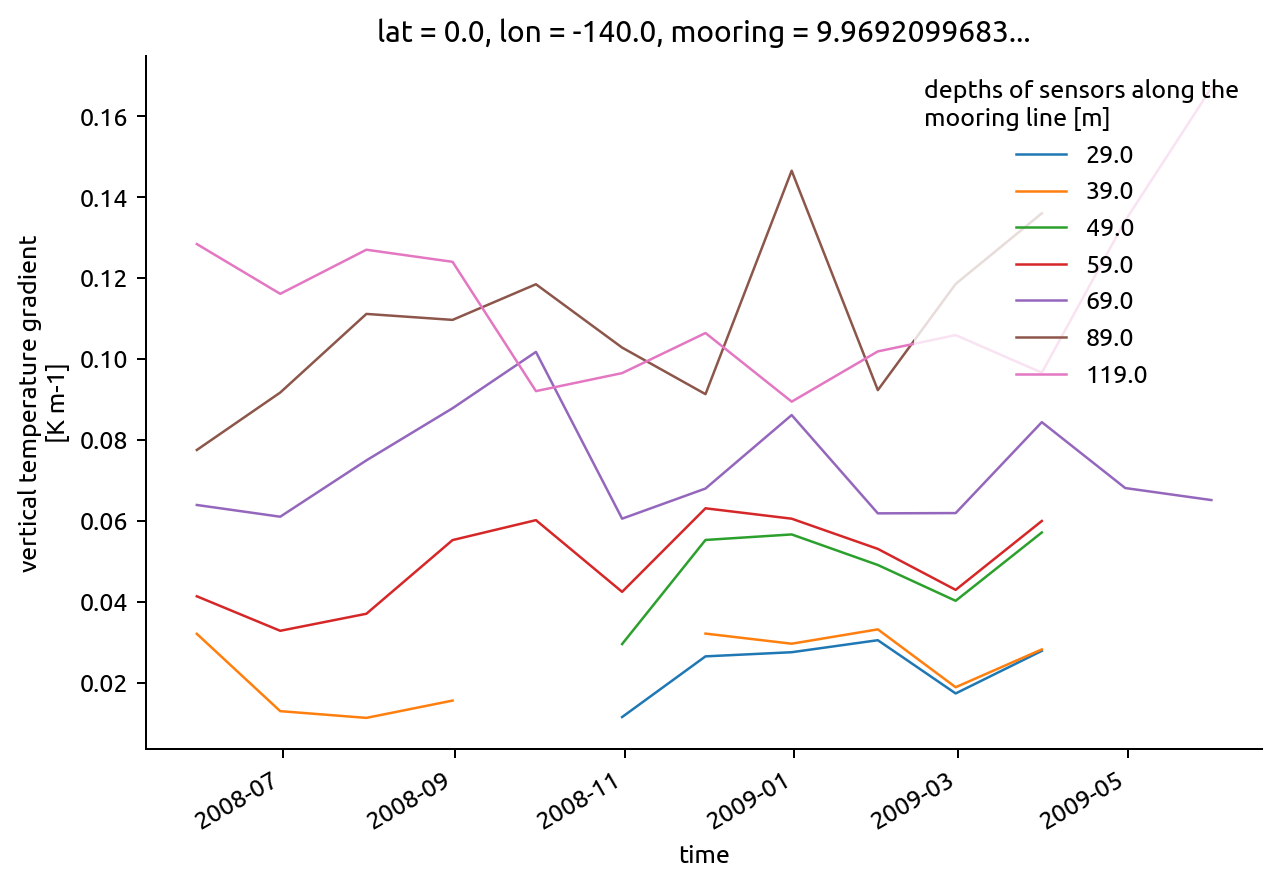

In [176]:
chisub.resample(time="M").mean().dTdz.plot.line(hue="depth")

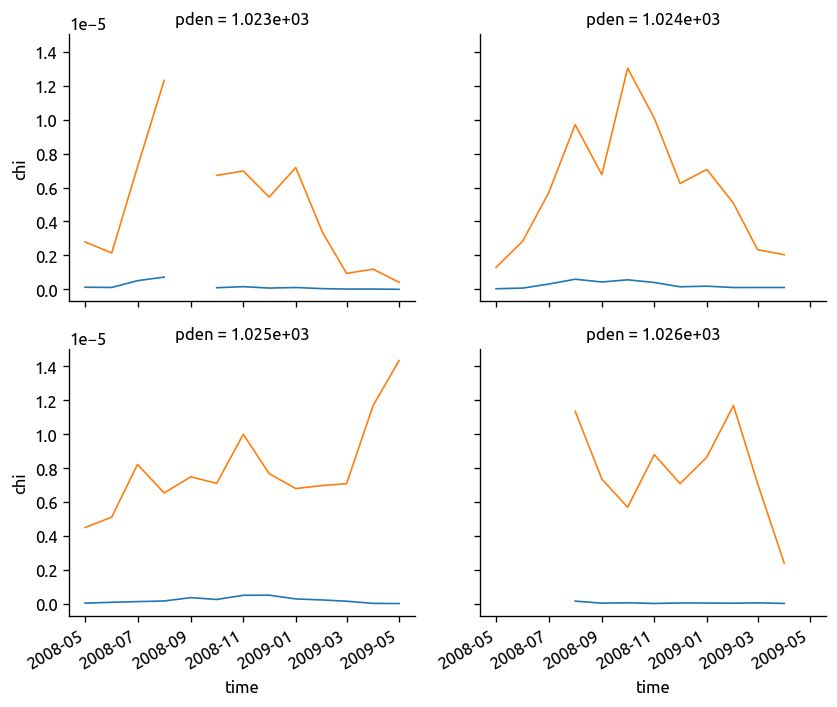

In [74]:
fg = (chidens["chi"]/2).plot(col="pden", col_wrap=2)
fg.data = chidens.KtTz
fg.map_dataarray_line(xr.plot.line, x="time", y=None, hue=None)

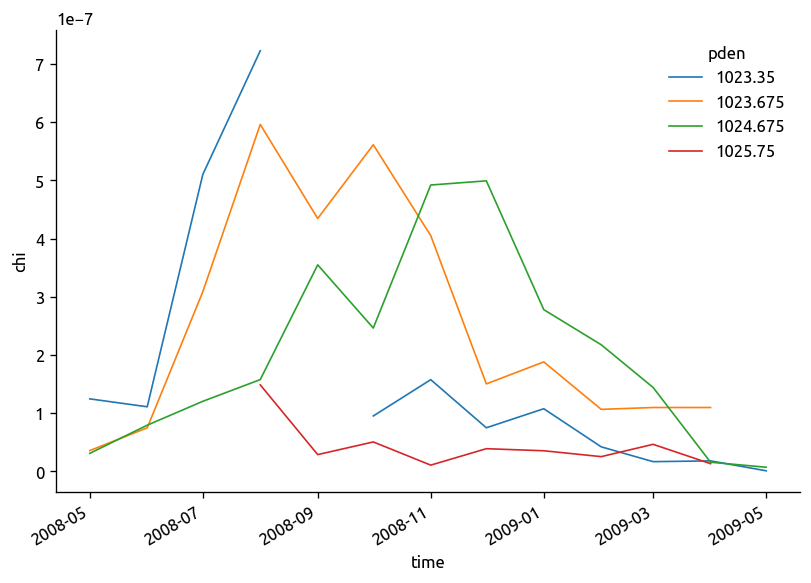

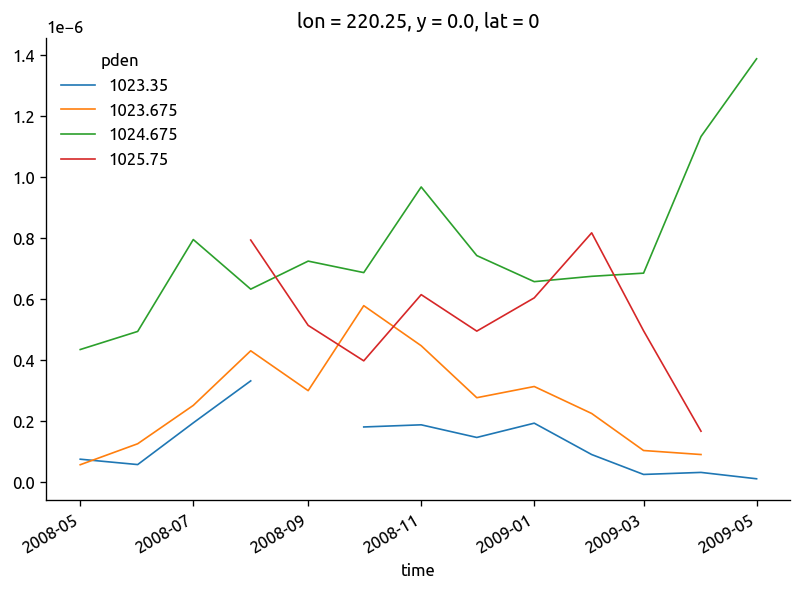

In [56]:
(chidens["chi"]/2).plot.line(hue="pden")
plt.figure()
(chidens["KtTz"] * isoT["dTdz"]).plot.line(hue="pden")

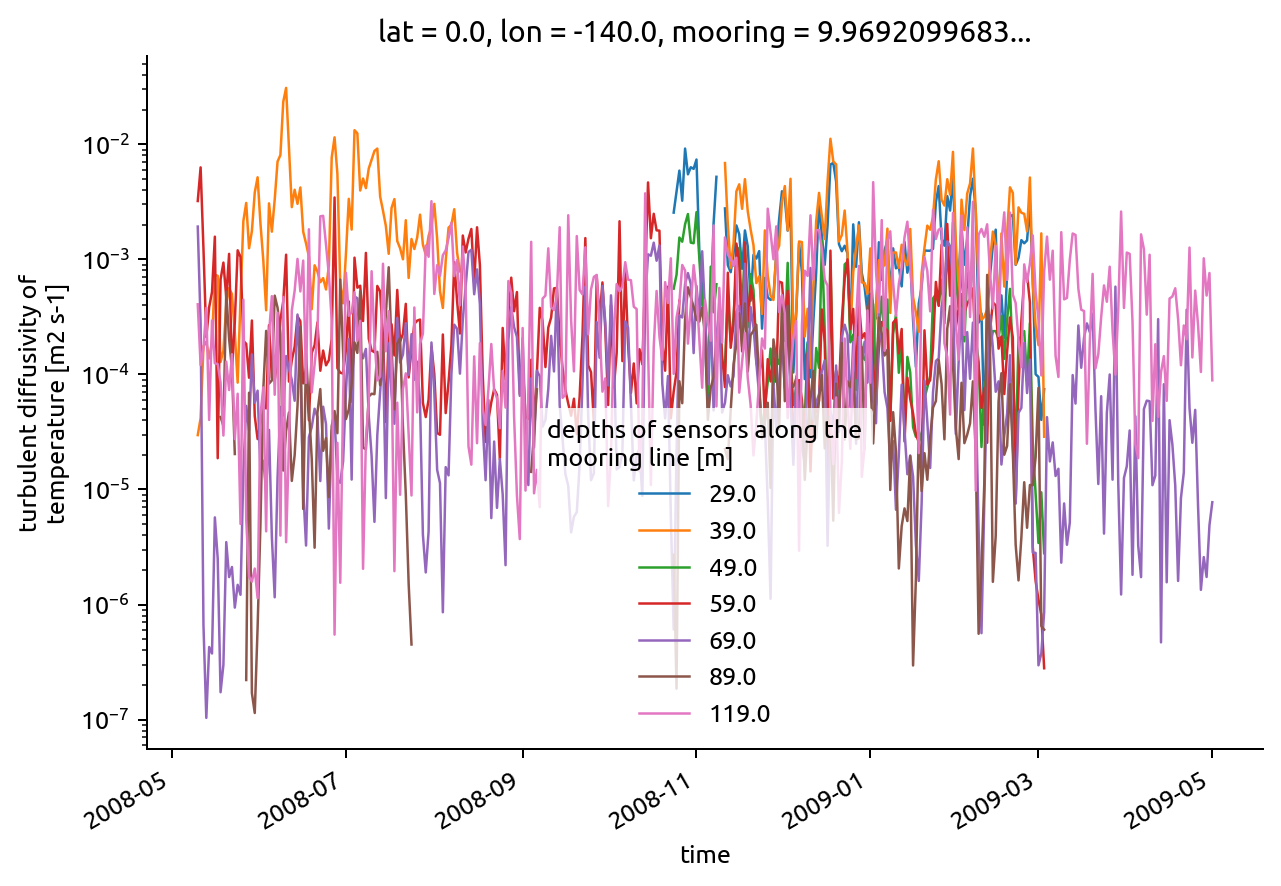

In [22]:
chisub.KT.resample(time="D").mean().plot.line(hue="depth", yscale="log")

## Testing χ

In [295]:
eccoT.dTdz.interp(lat=0)

<xarray.DataArray 'dTdz' (pden: 3)>
array([0.03427257, 0.096845  , 0.06992526])
Coordinates:
    lon          float64 220.2
  * pden         (pden) float64 1.024e+03 1.025e+03 1.026e+03
    dz_remapped  (pden) float64 49.35 69.1 35.2
    y            float64 0.0
    lat          int64 0

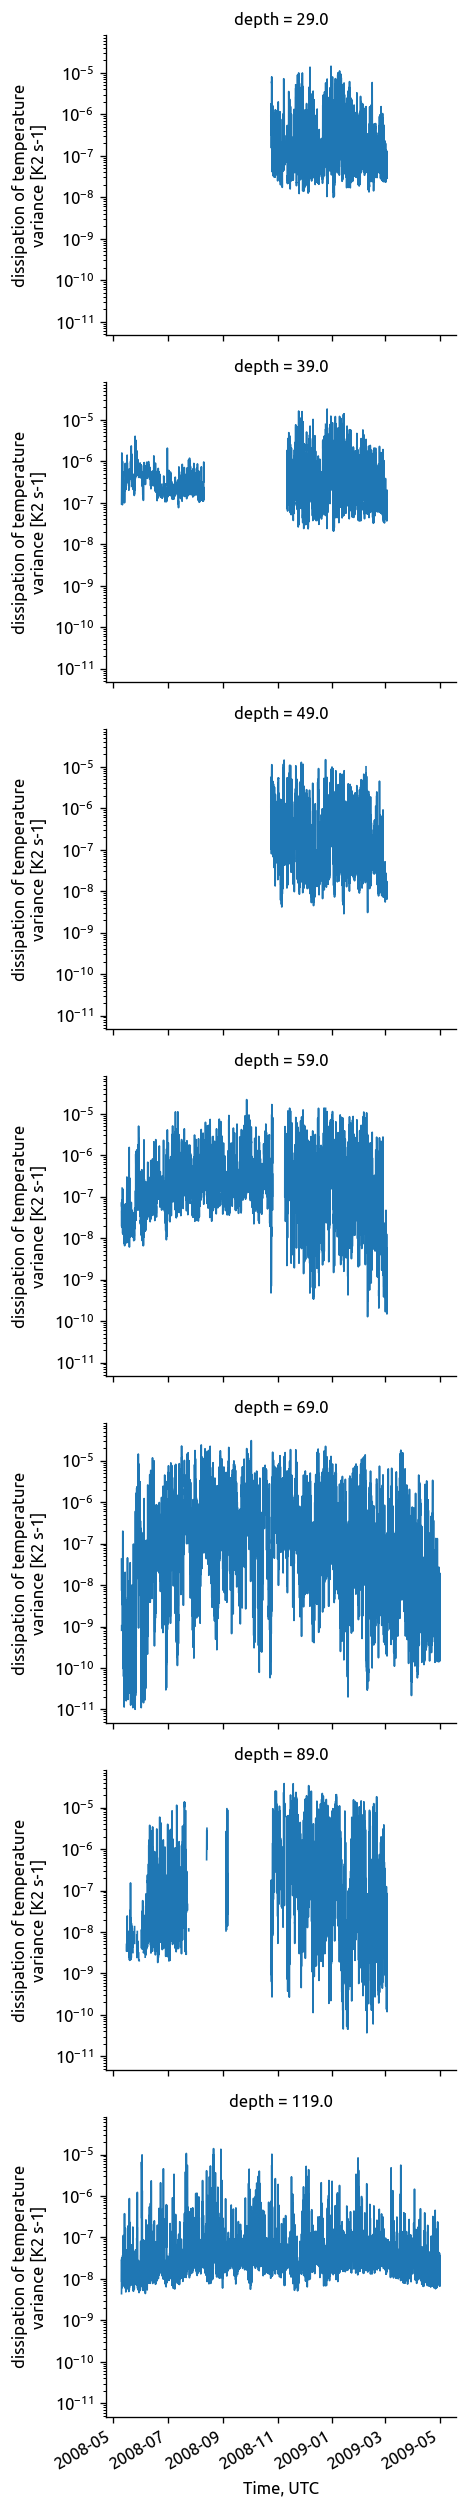

In [292]:
chisub.chi.plot.line(row="depth", yscale="log")

In [319]:
chi2.dTdz.mean().compute()

<xarray.DataArray 'dTdz' ()>
array(0.03167741)
Coordinates:
    lat      float64 0.0
    lon      float64 -140.0
    mooring  float64 9.969e+36
    chipod   float64 9.969e+36
Attributes:
    long_name:              vertical temperature gradient
    units:                  K m-1
    FillValue:              -9999
    valid_min:              4.9999999999999996e-06
    valid_max:              0.001
    coverage_content_type:  physicalMeasurement
    grid_mapping:           crs
    references:             Moum, J.N. and J.D. Nash, Mixing measurements on ...
    cell_methods:           depth: point, time: mean
    platform:               mooring
    instrument:             chipod

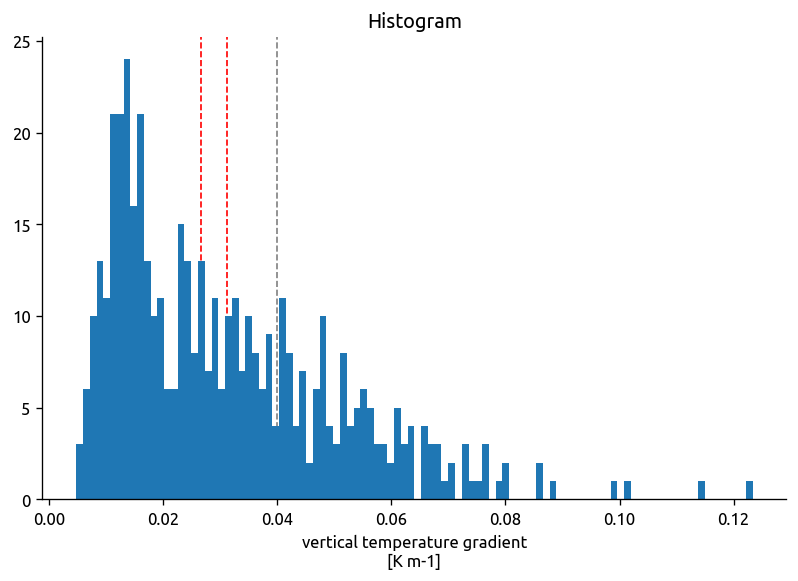

In [331]:
chi2.dTdz.plot.hist(bins=100);
dcpy.plots.linex(0.04)
dcpy.plots.linex(chi2.dTdz.mean(), color='r')
dcpy.plots.linex(chi2.dTdz.compute().median(), color='r')

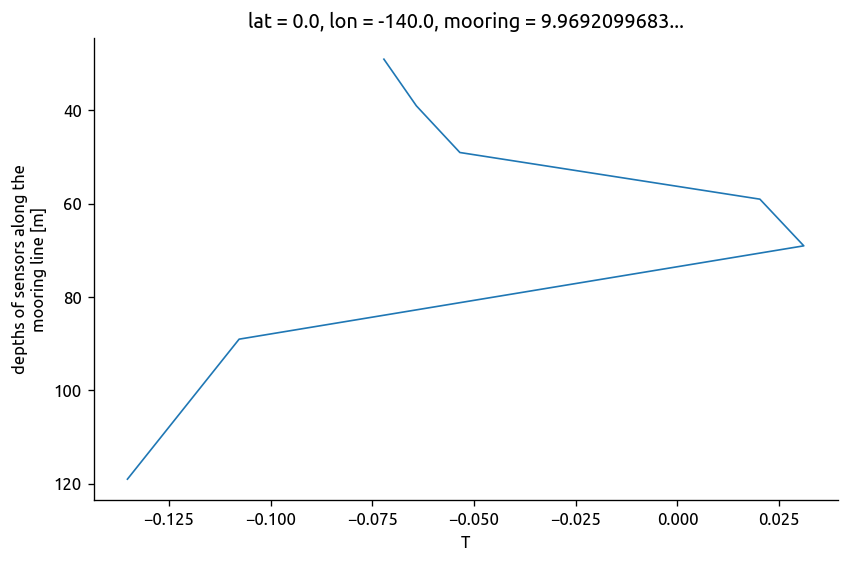

In [328]:
chisub.T.mean("time").differentiate("depth").plot(y="depth", yincrease=False)

use observed mean dTdz instead of cliamtological mean

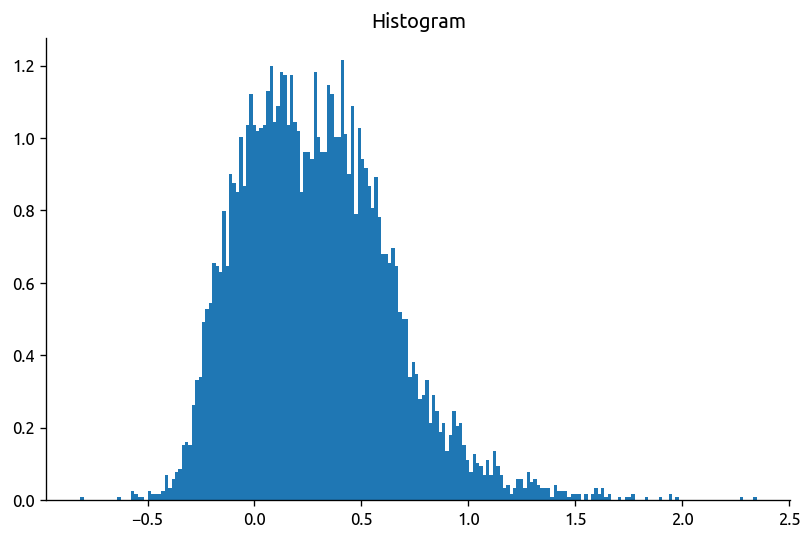

In [337]:
meanTz = 0.04
chi2 = chisub.sel(depth=slice(50)).where(chisub.KT < 1e-3).where(chisub.dTdz > 1e-2) #.resample(time="D").mean()
# chi2 = chi2.resample(time="D").mean()

np.log10((chi2.KtTz * meanTz) / (chi2.chi/2)).plot.hist(bins=200, density=True);
# np.log10((chi2.KtTz * meanTz) / (chi2.chi)).plot.hist(bins=200, density=True);

---
---

## Old stuff

In [ ]:
eccograd, argograd, cole, aber = ed.read_all_datasets(kind="monthly")

In [265]:
argograd.time.attrs["axis"] = "T"
argograd.pres.attrs["positive"] = "down"

/home/deepak/miniconda3/envs/dcpy/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8711 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/deepak/miniconda3/envs/dcpy/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8711 missing from current font.
  font.set_text(s, 0, flags=flags)


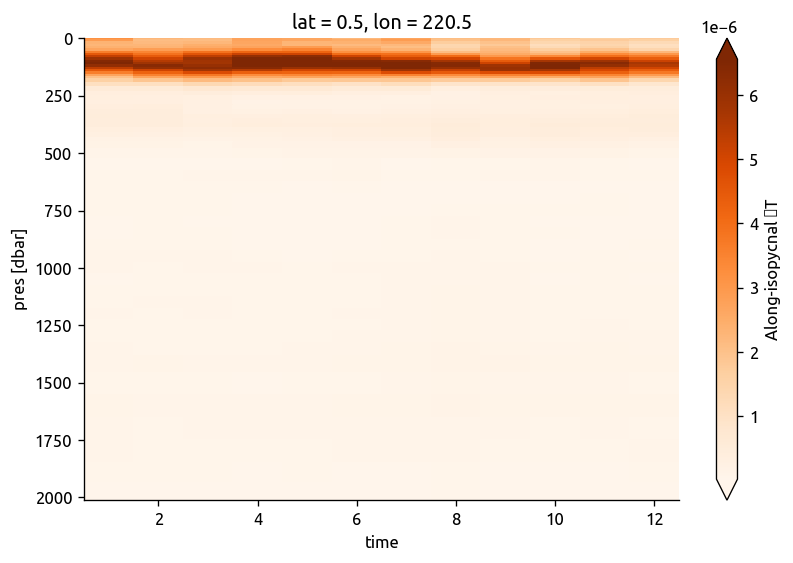

In [266]:
argograd.sel(lat=0, lon=360 - 140, method="nearest").dTiso.cf.plot.pcolormesh(
    y="Z", robust=True, cmap=mpl.cm.Oranges
)

In [26]:
chidens = binned.to_xarray()

In [27]:
grad, _ = ed.bin_to_density_space(
    argograd.sel(lat=0, lon=360 - 140, method="nearest").rename({"ρmean": "rho"}),
    bins=bins,
)
grad = grad.sel(time=chidens.time.dt.month.values).assign_coords(time=chidens.time)
grad

<xarray.Dataset>
Dimensions:   (rho: 4, time: 358)
Coordinates:
  * time      (time) datetime64[ns] 2008-05-10 2008-05-11 ... 2009-05-02
  * rho       (rho) float32 1022.75 1023.25 1024.5 1025.75
    lat       float32 0.5
    lon       float32 220.5
Data variables:
    pres      (time, rho) float64 15.62 50.0 95.0 140.0 ... 50.0 95.0 140.0
    Smean     (time, rho) float32 35.150955 35.16125 ... 35.08096 34.97392
    Tmean     (time, rho) float32 26.652958 25.90761 ... 21.142931 15.874863
    dSdia     (time, rho) float64 0.0004355 0.0007541 ... 0.002183 0.002707
    dSdz      (time, rho) float32 -0.00043551126 0.0005791346 ... 0.002706909
    dSiso     (time, rho) float64 1.038e-06 1.437e-06 ... 2.434e-06 1.457e-06
    dTdia     (time, rho) float64 0.009585 0.0497 0.127 ... 0.0497 0.127 0.08775
    dTdz      (time, rho) float32 0.009585428 0.04970134 ... 0.08775275
    dTiso     (time, rho) float64 2.479e-06 3.539e-06 ... 6.849e-06 5.099e-06
    mean_rho  (time, rho) float32 1022.9419 1023.1831 ... 1024.4943 1025.7537

In [28]:
chidens["rho"] = grad["rho"]

In [68]:
Ke = (chidens["chi"] / 2 - np.abs(chidens["KtTz"] * grad["dTdz"] / 3)) / (
    grad["dTiso"] ** 2
)
Ke

<xarray.DataArray (rho: 4, time: 358)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 11726.46725949,   8248.95985651,   5027.56820076, ...,
          -204.25370459,   -334.24473111,   -187.44859464],
       [ -1879.12790238, -12763.75317847, -15621.72404617, ...,
        -40449.6307827 , -59050.73202118, -58244.54230018],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])
Coordinates:
  * rho      (rho) float32 1022.75 1023.25 1024.5 1025.75
  * time     (time) datetime64[ns] 2008-05-10 2008-05-11 ... 2009-05-02
    lat      float32 0.5
    lon      float32 220.5

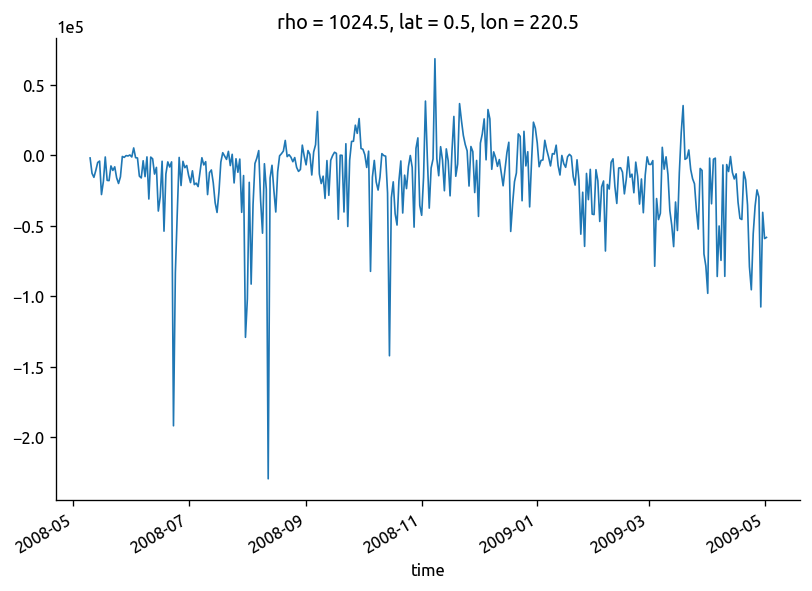

In [69]:
Ke.isel(rho=2).plot()

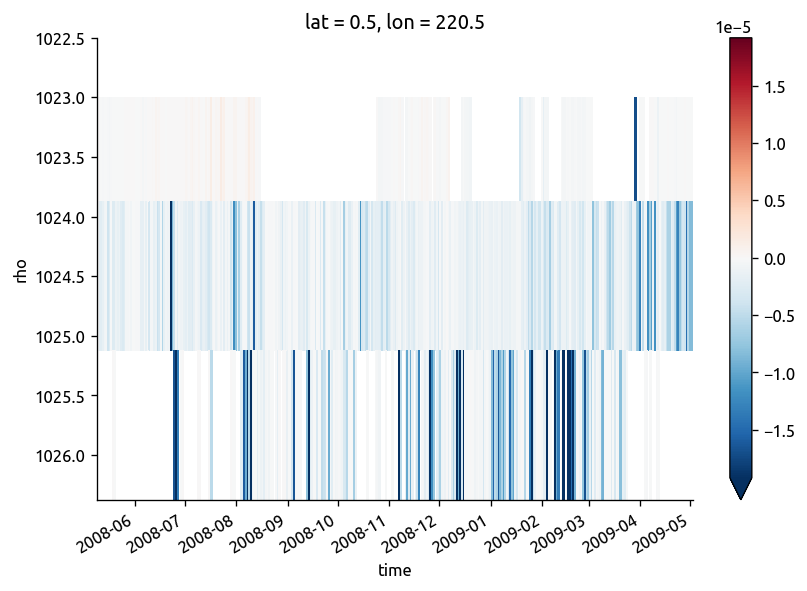

In [42]:
(chidens["chi"] / 2 - np.abs(chidens["KtTz"] * grad["dTdz"])).cf.plot(
    x="time", y="rho", robust=True
)